<a href="https://colab.research.google.com/github/JoeArmel/JoeArmel/blob/main/Lines_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install wandb

# ANALYSE DES MOTS ECRITS A LA MAIN

## Setup

In [ ]:
import os
import glob
import pathlib
from collections import Counter

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow import keras
from tensorflow.keras import layers

from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, Dropout
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical, Sequence

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from itertools import groupby


In [ ]:
import wandb
from wandb.keras import WandbCallback

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Création d'un dataframe contenant les chemin d'accès aux différents fichiers

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!ls "/content/drive/My Drive/"

 2lines_checkpoint.hdf5		   'OCR2 (1).html'
 AllWords_OCR.ipynb		    OCR2.ipynb
'Colab Notebooks'		   'OCR Pynsurances'
'Copie de 2lines_checkpoint.hdf5'   recherche.png
 essai				   'recherche repas.png'
 Exam_155.ipynb			    sentences
'Examen 161.ipynb'		    taste.png
 file.csv			    Test_OCR_WORDS.ipynb
 harmony.png			   'the roman.png'
 lines				    Untitled0.ipynb
 lines_checkpoint.hdf5		    words
 lines.tgz			    xml.csv
 menage.png


### Chargement du dossiers des

### Indication du chemin d'accès aux différentes images et décompte de celles-ci.

In [ ]:
# Chemin d'accès aux fichiers de phrases. Ce sont tous des fichiers .png
myDir = "/content/drive/My Drive/lines"

# Trouver toutes les chemins vers les fichiers qui finissent par .png

data_dir = pathlib.Path(myDir)

linespath = sorted(list(map(str, list(data_dir.glob("*/*/*.png")))))

# Nombre de fichiers trouvés
lines_count = len(linespath)
print('Nombre de fichiers images de lignes :',lines_count)

Nombre de fichiers images de lignes : 13353


### Construction d'un premier dataframe contenant les chemins d'accès et le nom des fichiers 

In [ ]:
# Extraction du label de chaque image
images = list(map(lambda x : [x, x.split('/')[-1].split(".png")[0]], linespath))

In [ ]:
# Création d'un dataframe
df = pd.DataFrame(images, columns=['filepath', 'lines_id'])
df.head()

filepath     lines_id
0  /content/drive/My Drive/lines/a01/a01-000u/a01...  a01-000u-00
1  /content/drive/My Drive/lines/a01/a01-000u/a01...  a01-000u-01
2  /content/drive/My Drive/lines/a01/a01-000u/a01...  a01-000u-02
3  /content/drive/My Drive/lines/a01/a01-000u/a01...  a01-000u-03
4  /content/drive/My Drive/lines/a01/a01-000u/a01...  a01-000u-04

### Exploitation du fichier xml pour la construction d'un second dataframe [nom du fichier, transcription]

<ul> Cette exploitation a pour objectif de coupler la transcription du mot contenu dans l'image, au nom du fichier de ladite image. </ul>

In [ ]:
#lecture du fichier XML créé précédement
fichier_xml = '/content/drive/My Drive/xml.csv'
fichier = pd.read_csv(fichier_xml,index_col=[0])

# Création du dataframe
df1 = fichier[['id','text']].rename({'id':'words_id','text':'label'}, axis = 1)

#### Suppression des doublons.
df1 = df1.drop_duplicates()

#### Tri par ordre croissant par rapport à la colonne 'words_id'.
df1 = df1.sort_values(by ='words_id', axis= 0)

df1.head()

words_id label
168047  a01-000u-00-00     A
168048  a01-000u-00-01  MOVE
168053  a01-000u-00-02    to
168055  a01-000u-00-03  stop
168058  a01-000u-00-04   Mr.

In [ ]:
# Création d'une colonne contenant les lines_id par 
# suppression des trois derniers caractères de chaque words_id

df1['lines_id'] = df1['words_id'].apply(lambda id : id[:-3])


# Suppression de la colonne words_id

df1= df1.drop(columns=['words_id'])


# réorganisation des colonnes de df1

df1 = df1[['lines_id', 'label']]


# Mise en forme du texte associé à chaque lines_id

df1 = df1.groupby('lines_id')['label'].apply(' '.join).reset_index()
df1.head()

lines_id                                  label
0  a01-000u-00      A MOVE to stop Mr. Gaitskell from
1  a01-000u-01  nominating any more Labour life Peers
2  a01-000u-02   is to be made at a meeting of Labour
3  a01-000u-03   M Ps tomorrow . Mr. Michael Foot has
4  a01-000u-04   put down a resolution on the subject

In [ ]:
df1.shape

(13353, 2)

In [ ]:
# Couplage des deux dataframes et création de notre dataset.
data = pd.merge(df, df1, on = ['lines_id'])
data.head()

filepath  ...                                  label
0  /content/drive/My Drive/lines/a01/a01-000u/a01...  ...      A MOVE to stop Mr. Gaitskell from
1  /content/drive/My Drive/lines/a01/a01-000u/a01...  ...  nominating any more Labour life Peers
2  /content/drive/My Drive/lines/a01/a01-000u/a01...  ...   is to be made at a meeting of Labour
3  /content/drive/My Drive/lines/a01/a01-000u/a01...  ...   M Ps tomorrow . Mr. Michael Foot has
4  /content/drive/My Drive/lines/a01/a01-000u/a01...  ...   put down a resolution on the subject

[5 rows x 3 columns]

In [ ]:
print('Nombre de labels uniques dans la transcription : ',len(data.label.unique()))

# Longueur maximale des transcriptions dans le dataset
max_length = max([len(label) for label in data.label])
print('\nValeur de la plus longue ligne : ', max_length)

# Longueur moyenne des lignes de texte dans le datframe
mean_length = np.mean([len(label) for label in data.label])
print('\nLongueur moyenne d\'une ligne : ', round(mean_length, 2))

Nombre de labels uniques dans la transcription :  12778

Valeur de la plus longue ligne :  93

Longueur moyenne d'une ligne :  43.24


In [ ]:
# Ici nous effectuons un tri pour savoir quels sont les mots les plus longs

for index, txt in enumerate(data.label):
    if len(txt) >= 80 :# max_length - 35 :
        print('Indice : ',index, 'Mot : ',txt, 'Longueur :', len(txt))

Indice :  3694 Mot :  Become a success with a disc and hey presto ! You 're a star ... . Rolly sings with Longueur : 83
Indice :  3695 Mot :  assuredness " Bella Bella Marie " ( Parlophone ) , a lively song that changes tempo mid-way . Longueur : 93
Indice :  3698 Mot :  He is also a director of a couple of garages . And he finds time as well to be a lyric Longueur : 86
Indice :  3699 Mot :  writer . He writes with Tolchard Evans , composer of " Lady of Spain " and other big hits . Longueur : 91
Indice :  3700 Mot :  Tolch , as he is known in Tin Pan Alley , likes songs with a month in the title . He wrote Longueur : 90
Indice :  3998 Mot :  plan and to the different public for which , or against which , the author wrote . Longueur : 82
Indice :  4274 Mot :  Self-control gives us : Freedom to worship God . ( 3 ) Salt Water and Charauses : Longueur : 81
Indice :  11205 Mot :  " Good-bye , Morfydd . He sought to enfold her in his arms . But he was too late . Longueur : 82
Indice :  11207

## VISUALISATION DE QUELQUES IMAGES AVEC LEUR TRANSCRIPTION

In [ ]:
from matplotlib.image import imread

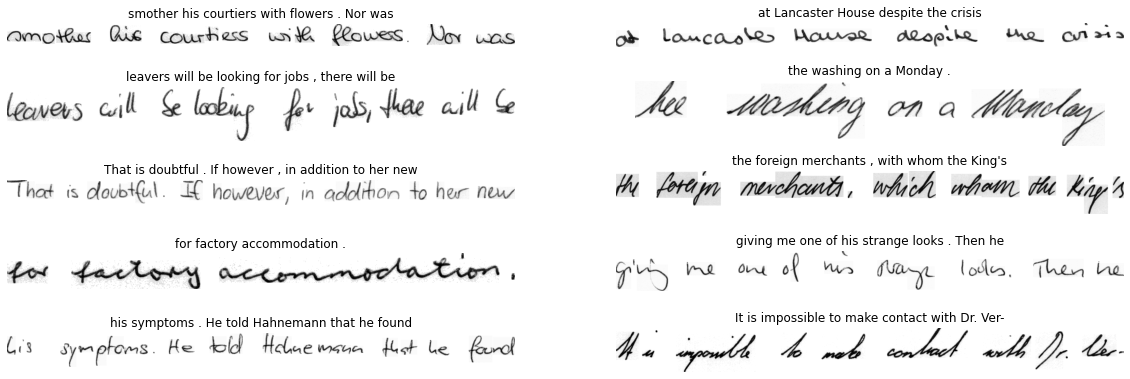

In [ ]:
#Visualisation aléatoire de quelques données images.
plt.figure(figsize=(20, 7))

j=1
for i in np.random.choice(range(data.shape[0]), size = 10):
    ax = plt.subplot(5, 2, j)
    plt.imshow(imread(data.filepath[i]), cmap='gray')
    plt.title(data.label[i])
    j+=1
    plt.axis("off")

## Identification de tous les caractères présents dans la transcription

<ul> Ceci se fait par la construction d'un vocabulaire des différents caractères présents dans toute la transcription. La méthode employée permet de créer une liste de caractères triés par ordre décroissant d'occurrence. Ainsi, les indices les plus grands sont reservés au caractères les moins fréquents dans la transcription tandis que les indices les plus petits sont occupés par les caractères les plus souvent présents. Un caratère <b>[UNK]</b> est ajouté au vocabulaire pour nommer tout caractère qui se trouve hors du dictionnaire.</ul>

In [ ]:
K = list(char for label in data.label for char in label) # liste de tous les caractères avec eventuellement des doublons

layer = layers.experimental.preprocessing.StringLookup() # Instanciation d'un objet StringLookup

layer.adapt(K)                                         # Cette opération filtre l'ensemble K en identifiant les valeurs uniques

Vocab = layer.get_vocabulary()                         # Vocabulaire filtré et trié par ordre décroissant d'occurrence

In [ ]:
print('Vocabulaire des caractères présents :', Vocab)

print("Nombre de caractères uniques :", len(Vocab))

Vocabulaire des caractères présents : ['', '[UNK]', ' ', 'e', 't', 'a', 'o', 'n', 'i', 's', 'r', 'h', 'l', 'd', 'u', 'c', 'm', 'f', 'w', 'g', 'y', 'p', 'b', '.', ',', 'v', 'k', "'", 'T', 'I', '"', '-', 'A', 'M', 'S', 'H', 'B', 'x', 'C', 'W', 'P', 'N', 'E', 'G', 'L', 'R', 'D', '1', 'F', 'O', '0', 'j', 'q', '?', 'Y', '!', '2', 'z', ';', '(', ')', 'U', 'J', '9', '3', 'V', ':', 'K', '5', '6', '8', '4', '#', '7', '&', 'Q', '/', '*', 'Z', '+', 'X']
Nombre de caractères uniques : 81


## Preprocessing

In [ ]:
# Association des caractères aux entiers. Ceci servira pour l'encodage des labels
char_to_num = layers.experimental.preprocessing.StringLookup(vocabulary = Vocab)

# Association des entiers aux caractères. Ceci servira pour le décodage des labels codés.
num_to_char = layers.experimental.preprocessing.StringLookup(vocabulary = char_to_num.get_vocabulary(), invert = True)

### Encodage et uniformisation de l'encodage des mots 

<ul> La fonction definie ci-dessous va permettre d'encoder chaque caractère présent dans la transcription de chaque image. L'objectif ici étant de pouvoir encoder chaque mot transcrit à l'aide des différents caractères qui le constituent.</ul>

In [ ]:
def encode_to_labels(txt):
    ''' Cette fonction transforme un mot en une liste de nombres.
    La liste a la longueur du mot qu'il remplace et est remplie de la gauche vers la droite. 
    Chaque nombre indique le rang de la lettre qu'il remplace.
    ''' 
    
    dig_lst = []
    for index, char in enumerate(txt):
        dig_lst.append(Vocab.index(char))
    return dig_lst

<ul>A présent, nous allons appliquer cette fonction au dataframe <b>'data'</b> en vue de l'encodage de la colonne <b>'label'</b>.</ul>

In [ ]:
# Nous commençons par encoder chaque ligne de mots à l'aide de la fonction encode_to_labels

data['encoded_label'] = data.label.apply(lambda txt: encode_to_labels(txt))
data.head()

filepath  ...                                      encoded_label
0  /content/drive/My Drive/lines/a01/a01-000u/a01...  ...  [32, 2, 33, 49, 65, 42, 2, 4, 6, 2, 9, 4, 6, 2...
1  /content/drive/My Drive/lines/a01/a01-000u/a01...  ...  [7, 6, 16, 8, 7, 5, 4, 8, 7, 19, 2, 5, 7, 20, ...
2  /content/drive/My Drive/lines/a01/a01-000u/a01...  ...  [8, 9, 2, 4, 6, 2, 22, 3, 2, 16, 5, 13, 3, 2, ...
3  /content/drive/My Drive/lines/a01/a01-000u/a01...  ...  [33, 2, 40, 9, 2, 4, 6, 16, 6, 10, 10, 6, 18, ...
4  /content/drive/My Drive/lines/a01/a01-000u/a01...  ...  [21, 14, 4, 2, 13, 6, 18, 7, 2, 5, 2, 10, 3, 9...

[5 rows x 4 columns]

#### Uniformisation de l'encodage

In [ ]:
# Nous créons ici un array numpy pour procéder à l'uniformisation de l'encodage 
#liste = data['encoded_label'].to_numpy()

# Uniformisation
pad_words = pad_sequences(data['encoded_label'].to_numpy(),
                          maxlen= max_length,
                          padding='post',
                          value = 0)

#### Mise à jour du dataframe avec l'encodage uniformisé

In [ ]:
# Duplication de la colonne ['encoded_words'] avec pour titre ['padded_words']

data['pad_label'] = data['encoded_label']


# Mise à jour de la colonne ['pad_label']

for index in range(len(data['pad_label'])):
    data['pad_label'][index] = pad_words[index]

data.head()

filepath  ...                                          pad_label
0  /content/drive/My Drive/lines/a01/a01-000u/a01...  ...  [32, 2, 33, 49, 65, 42, 2, 4, 6, 2, 9, 4, 6, 2...
1  /content/drive/My Drive/lines/a01/a01-000u/a01...  ...  [7, 6, 16, 8, 7, 5, 4, 8, 7, 19, 2, 5, 7, 20, ...
2  /content/drive/My Drive/lines/a01/a01-000u/a01...  ...  [8, 9, 2, 4, 6, 2, 22, 3, 2, 16, 5, 13, 3, 2, ...
3  /content/drive/My Drive/lines/a01/a01-000u/a01...  ...  [33, 2, 40, 9, 2, 4, 6, 16, 6, 10, 10, 6, 18, ...
4  /content/drive/My Drive/lines/a01/a01-000u/a01...  ...  [21, 14, 4, 2, 13, 6, 18, 7, 2, 5, 2, 10, 3, 9...

[5 rows x 5 columns]

# Création des objets Dataset

In [ ]:
# Séparation des données en entrainement et test

X_train_path, X_test_path, Y_train, Y_test = train_test_split(data.filepath, data.pad_label, train_size = .8, random_state = 1234)

In [ ]:
img_height = 32
img_width = 800

def encode_single_image(img_path, label):
    
    # 1. lecture de l'image
    img = tf.io.read_file(img_path)
    # 2. Decodage et conversion en échelle de gris
    img = tf.io.decode_png(img, channels=1)
    # 3. Normalisation de l'image. Les valeurs des
    # pixels sont désormais entre 0 et 1.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Redimensionnement de l'image au format désiré
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transposition de l'image pour faire correspondre
    # la dimension 'temps' à la dimension 'width' de l'image.
    img = tf.transpose(img, perm=[1, 0, 2])
    
    return {"image":img, "label": label}


batch_size = 100

# Entrainement
train_data = tf.data.Dataset.from_tensor_slices((X_train_path, Y_train.to_list()))

train_data = train_data.map(encode_single_image)

train_data = train_data.shuffle(buffer_size = 2000)

train_data = train_data.batch(batch_size = batch_size)

# Validation ou test
validation_data = tf.data.Dataset.from_tensor_slices((X_test_path, Y_test.to_list()))

validation_data = validation_data.map(encode_single_image)

validation_data = validation_data.shuffle(buffer_size = 2000)

validation_data = validation_data.batch(batch_size = batch_size)

## Visualisation

In [ ]:
wandb.init(project="Lines_text_ORC", name="log_images")

wandb: Currently logged in as: josepharmel (use `wandb login --relogin` to force relogin)


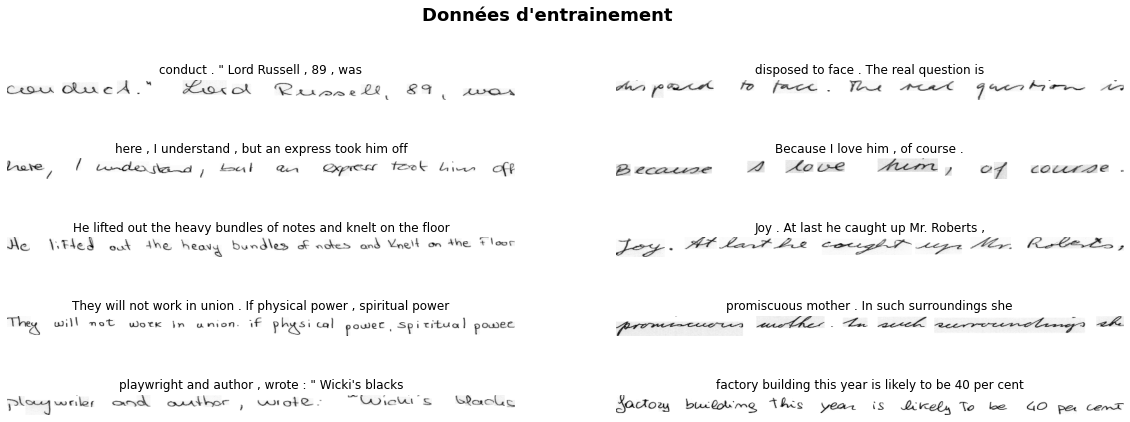

In [ ]:
train_data_fig, ax = plt.subplots(5, 2, figsize=(20, 7))
train_data_fig.suptitle('Données d\'entrainement', weight = 'bold', size = 18)

for batch in train_data.take(1):
    
    images = batch["image"]
    labels = batch["label"]    
    
    for i in range(10):
        
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("UTF-8")

        ax[i % 5, i % 2].imshow(img[:, :, 0].T, cmap="gray")
        ax[i % 5, i % 2].set_title(label)
        ax[i % 5, i % 2].axis("off")

plt.show()

wandb.log({"traindata2": train_data_fig})

# Le modèle

In [ ]:
## ref :  https://keras.io/examples/vision/captcha_ocr/

class CTCLayer(layers.Layer):

    def __init__(self, name=None):

        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
        
    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
        
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        
        
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # Au moment de tester, retourner juste les prédictions
        return y_pred



In [ ]:
# Fonction de décodage des prédictions

def ctc_decoder(predictions):
    '''
    input: batch de prédictions issues du modèle
    
    output: retourne des listes de textes décodés

    '''
    text_list = []
    
    pred_indcies = np.argmax(predictions, axis=2)
    
    for i in range(pred_indcies.shape[0]):
        ans = ""
        
        ## merge repeats
        merged_list = [k for k,_ in groupby(pred_indcies[i])]
        
        ## retrait des caractères vides
        for p in merged_list:
            if p != len(Vocab):
                ans += Vocab[int(p)]
        
        text_list.append(ans)
        
    return text_list

In [ ]:
## Ref : 

figures_list = []

# Ici, nous definissons un callback pour l'affichage des prédictions à l'issue de certains epochs

class PlotPredictions(tf.keras.callbacks.Callback):

    def __init__(self, frequency=5):
        self.frequency = frequency
        super(PlotPredictions, self).__init__()

        batch = validation_data.take(1)
        self.batch_images = list(batch.as_numpy_iterator())[0]["image"]
        self.batch_labels = list(batch.as_numpy_iterator())[0]["label"]

    def plot_predictions(self, epoch):

        prediction_model = keras.models.Model(
            self.model.get_layer(name="image").input, 
            self.model.get_layer(name="dense").output
        )
        
        preds = prediction_model.predict(self.batch_images)
        pred_texts = ctc_decoder(preds)

        orig_texts = []

        for label in self.batch_labels:
            orig_texts.append("".join([Vocab[int(char_ind)] for char_ind in label if not(char_ind == len(Vocab))]))

        fig , ax = plt.subplots(5, 2, figsize=(20, 7))
        fig.suptitle('Epoch: '+str(epoch), weight='bold', size=14)

        for i in range(10):

            img = (self.batch_images[i, :, :, 0] * 255).astype("uint8")
            img = img.T
            title = f"Prediction: {pred_texts[i]}"
            ax[i % 5, i % 2].imshow(img, cmap="gray")
            ax[i % 5, i % 2].set_title(title)
            ax[i % 5, i % 2].axis("off")
        
        plt.show()
        plt.savefig("predictions_epoch_"+ str(epoch)+'.png', bbox_inches = 'tight', pad_inches = 0)
        
        figures_list.append(fig)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:
            self.plot_predictions(epoch)

In [ ]:
def train(epochs):
    
    # input with shape of height=32 and width=800 
    inputs = Input(shape=(img_width, img_height, 1), name="image")

    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    conv_1 = Conv2D(32, (3,3), activation = "selu", padding='same')(inputs)
    pool_1 = MaxPool2D(pool_size=(2,2))(conv_1)
    
    conv_2 = Conv2D(64, (3,3), activation = "selu", padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2))(conv_2)

    conv_3 = Conv2D(128, (3,3), activation = "selu", padding='same')(pool_2)
    conv_4 = Conv2D(128, (3,3), activation = "selu", padding='same')(conv_3)

    pool_4 = MaxPool2D(pool_size=(1, 2))(conv_4)
    
    conv_5 = Conv2D(256, (3,3), activation = "selu", padding='same')(pool_4)
    
    # Batch normalization layer
    batch_norm_5 = BatchNormalization()(conv_5)
    
    conv_6 = Conv2D(256, (3,3), activation = "selu", padding='same')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(1, 2))(batch_norm_6)
        
    conv_7 = Conv2D(64, (2,2), activation = "selu")(pool_6)
    
    squeezed = Lambda(lambda x: K.squeeze(x, 2))(conv_7)
    
    dropout= Dropout(0.2)(squeezed)
    
    # bidirectional LSTM layers with units=128
    blstm_1 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(squeezed)
    blstm_2 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(blstm_1)

    softmax_output = Dense(len(Vocab) + 1, activation = 'softmax', name="dense")(blstm_2)

    output = CTCLayer(name="ctc_loss")(labels, softmax_output)


    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    # le modèle à utiliser pour l'entrainement
    model = Model(inputs=[inputs, labels], outputs=output, name="ocr_model_line")
    model.compile(optimizer = optimizer)

    print(model.summary())
    
    return model

model = train(epochs=100)

Model: "ocr_model_line"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 800, 32, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 800, 32, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 400, 16, 32)  0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 400, 16, 64)  18496       max_pooling2d_4[0][0]            
_____________________________________________________________________________________

In [ ]:
file_path = "/content/drive/My Drive/lines_checkpoint.hdf5"
    
## Les callbacks

# Ajoutd'un early stopping
early_stopping = keras.callbacks.EarlyStopping(restore_best_weights=True,
                                               verbose=1)

In [ ]:


# Sauvegarde des poids à chaque epoch
checkpoint = keras.callbacks.ModelCheckpoint(filepath = file_path, 
                                             monitor = 'val_loss',
                                             save_best_only = True,
                                             save_weights_only = False,
                                             verbose = 1,
                                             mode = 'min',
                                             save_freq = 'epoch')

# Ceci est callback qui permet de synchroniser l'entrainement avec la plate forme wandb, et y stocker toutes les données de l'entrainement.
#  Le paramètre controlé est "validation loss"
wandbcall = WandbCallback(monitor="val_loss",
                          mode="min", 
                          log_weights=True)

# PlotPredictions est un autre callback qui permet d'afficher la prédiction du modèle au fur et à mesure que l'entrainement avance.  
callbacks_list = [checkpoint, 
                  wandbcall,
                  PlotPredictions(frequency=10),
                  early_stopping]

Epoch 1/350
107/107 [==============================] - 80s 701ms/step - loss: 45.4494 - val_loss: 67.5230

Epoch 00001: val_loss did not improve from 67.34274


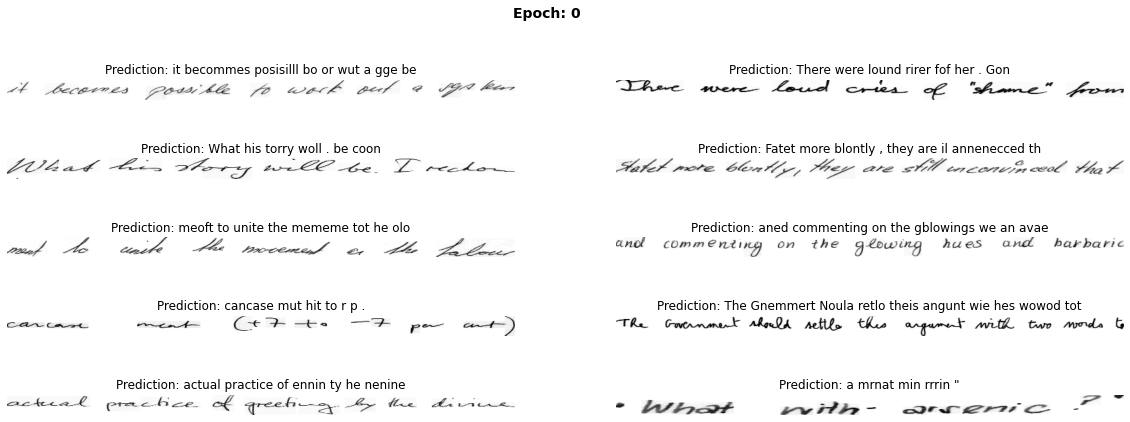

Epoch 2/350
107/107 [==============================] - 80s 694ms/step - loss: 44.7780 - val_loss: 68.4920

Epoch 00002: val_loss did not improve from 67.34274
Epoch 3/350
107/107 [==============================] - 79s 693ms/step - loss: 45.5823 - val_loss: 72.5994

Epoch 00003: val_loss did not improve from 67.34274
Epoch 4/350
107/107 [==============================] - 80s 697ms/step - loss: 46.9137 - val_loss: 68.5039

Epoch 00004: val_loss did not improve from 67.34274
Epoch 5/350
107/107 [==============================] - 80s 695ms/step - loss: 45.5970 - val_loss: 71.0371

Epoch 00005: val_loss did not improve from 67.34274
Epoch 6/350
107/107 [==============================] - 79s 695ms/step - loss: 45.4067 - val_loss: 69.2363

Epoch 00006: val_loss did not improve from 67.34274
Epoch 7/350
107/107 [==============================] - 79s 692ms/step - loss: 44.9460 - val_loss: 68.6389

Epoch 00007: val_loss did not improve from 67.34274
Epoch 8/350
107/107 [=========================

<Figure size 432x288 with 0 Axes>

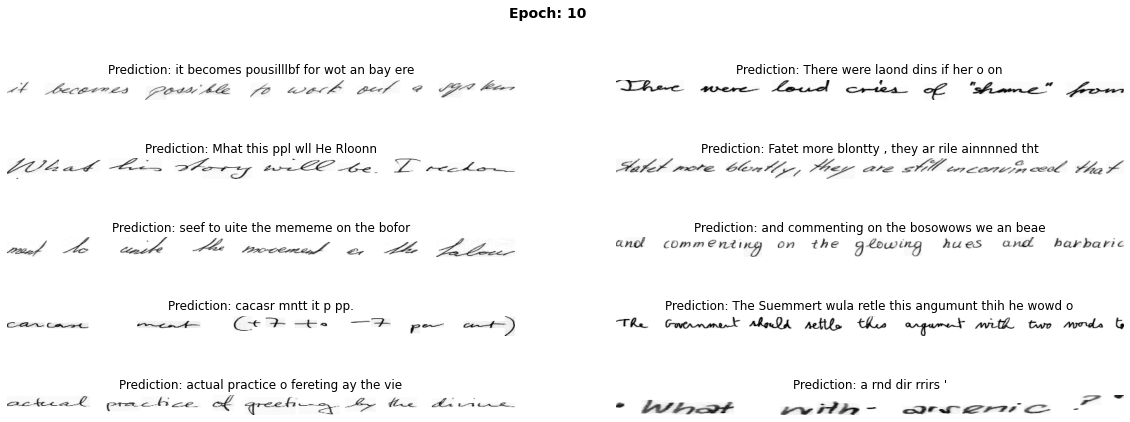

Epoch 12/350
107/107 [==============================] - 79s 693ms/step - loss: 43.4128 - val_loss: 73.0392

Epoch 00012: val_loss did not improve from 67.34274
Epoch 13/350
107/107 [==============================] - 80s 701ms/step - loss: 44.7201 - val_loss: 71.2595

Epoch 00013: val_loss did not improve from 67.34274
Epoch 14/350
107/107 [==============================] - 80s 698ms/step - loss: 44.6277 - val_loss: 74.7875

Epoch 00014: val_loss did not improve from 67.34274
Epoch 15/350
107/107 [==============================] - 81s 705ms/step - loss: 45.1521 - val_loss: 71.3852

Epoch 00015: val_loss did not improve from 67.34274
Epoch 16/350
107/107 [==============================] - 81s 705ms/step - loss: 43.5118 - val_loss: 68.9573

Epoch 00016: val_loss did not improve from 67.34274
Epoch 17/350
107/107 [==============================] - 81s 707ms/step - loss: 43.5462 - val_loss: 70.1454

Epoch 00017: val_loss did not improve from 67.34274
Epoch 18/350
107/107 [==================

<Figure size 432x288 with 0 Axes>

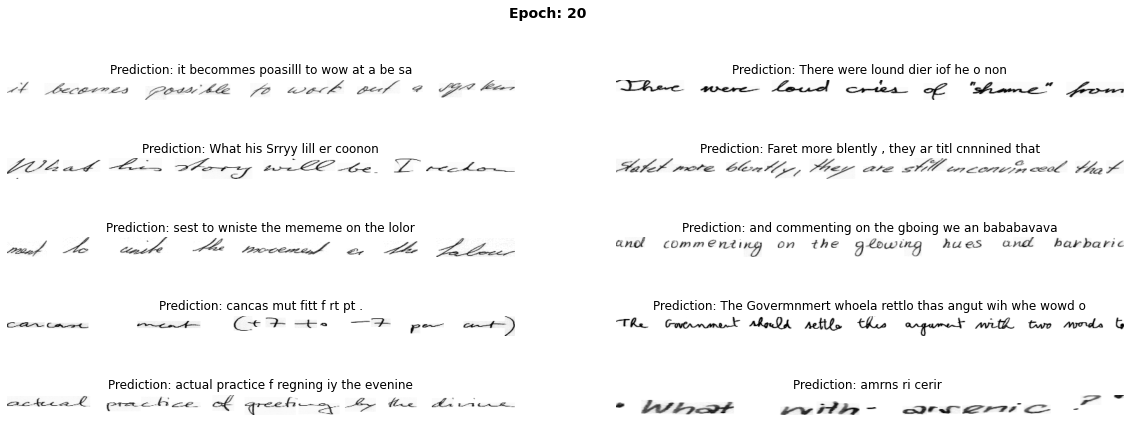

Epoch 22/350
107/107 [==============================] - 78s 682ms/step - loss: 42.7740 - val_loss: 67.9346

Epoch 00022: val_loss did not improve from 67.34274
Epoch 23/350
107/107 [==============================] - 79s 687ms/step - loss: 42.8359 - val_loss: 68.3020

Epoch 00023: val_loss did not improve from 67.34274
Epoch 24/350
107/107 [==============================] - 78s 684ms/step - loss: 43.2323 - val_loss: 70.1134

Epoch 00024: val_loss did not improve from 67.34274
Epoch 25/350
107/107 [==============================] - 79s 686ms/step - loss: 42.9020 - val_loss: 68.1260

Epoch 00025: val_loss did not improve from 67.34274
Epoch 26/350
107/107 [==============================] - 78s 684ms/step - loss: 42.8378 - val_loss: 67.3988

Epoch 00026: val_loss did not improve from 67.34274
Epoch 27/350
107/107 [==============================] - 79s 687ms/step - loss: 41.4792 - val_loss: 67.9924

Epoch 00027: val_loss did not improve from 67.34274
Epoch 28/350
107/107 [==================

<Figure size 432x288 with 0 Axes>

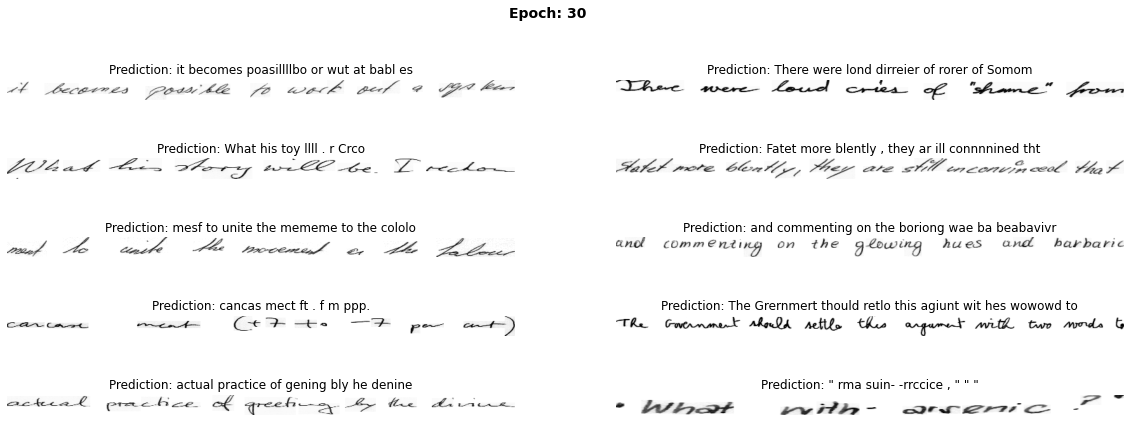

Epoch 32/350
107/107 [==============================] - 78s 679ms/step - loss: 40.9941 - val_loss: 70.2267

Epoch 00032: val_loss did not improve from 66.26599
Epoch 33/350
107/107 [==============================] - 79s 686ms/step - loss: 40.3742 - val_loss: 70.1430

Epoch 00033: val_loss did not improve from 66.26599
Epoch 34/350
107/107 [==============================] - 79s 686ms/step - loss: 42.0030 - val_loss: 66.3800

Epoch 00034: val_loss did not improve from 66.26599
Epoch 35/350
107/107 [==============================] - 79s 689ms/step - loss: 40.9104 - val_loss: 68.8332

Epoch 00035: val_loss did not improve from 66.26599
Epoch 36/350
107/107 [==============================] - 78s 686ms/step - loss: 41.1252 - val_loss: 68.7239

Epoch 00036: val_loss did not improve from 66.26599
Epoch 37/350
107/107 [==============================] - 79s 687ms/step - loss: 41.9709 - val_loss: 68.4767

Epoch 00037: val_loss did not improve from 66.26599
Epoch 38/350
107/107 [==================

<Figure size 432x288 with 0 Axes>

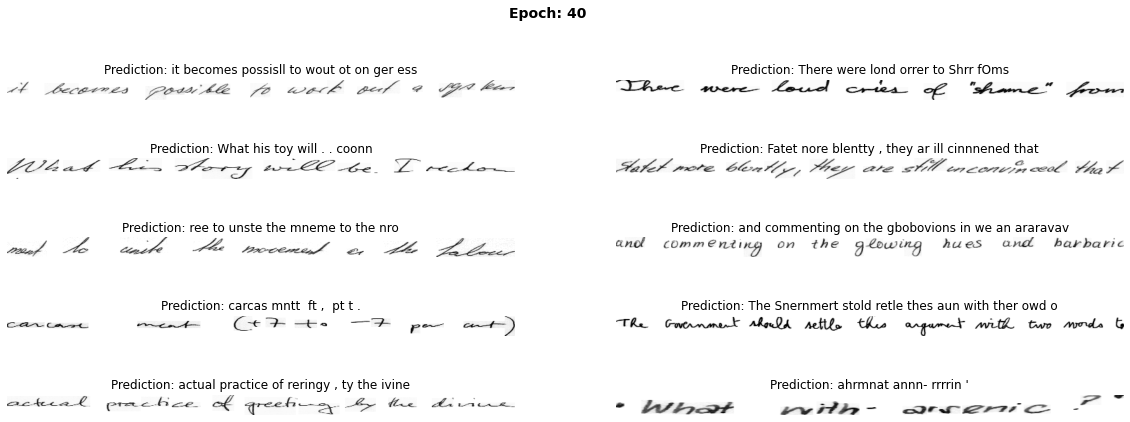

Epoch 42/350
107/107 [==============================] - 78s 679ms/step - loss: 40.7440 - val_loss: 74.1196

Epoch 00042: val_loss did not improve from 66.26599
Epoch 43/350
107/107 [==============================] - 79s 687ms/step - loss: 40.1282 - val_loss: 69.0680

Epoch 00043: val_loss did not improve from 66.26599
Epoch 44/350
107/107 [==============================] - 78s 687ms/step - loss: 39.6912 - val_loss: 67.9606

Epoch 00044: val_loss did not improve from 66.26599
Epoch 45/350
107/107 [==============================] - 78s 685ms/step - loss: 40.6469 - val_loss: 83.5995

Epoch 00045: val_loss did not improve from 66.26599
Epoch 46/350
107/107 [==============================] - 78s 687ms/step - loss: 39.9251 - val_loss: 71.7745

Epoch 00046: val_loss did not improve from 66.26599
Epoch 47/350
107/107 [==============================] - 79s 690ms/step - loss: 40.1642 - val_loss: 70.7969

Epoch 00047: val_loss did not improve from 66.26599
Epoch 48/350
107/107 [==================

<Figure size 432x288 with 0 Axes>

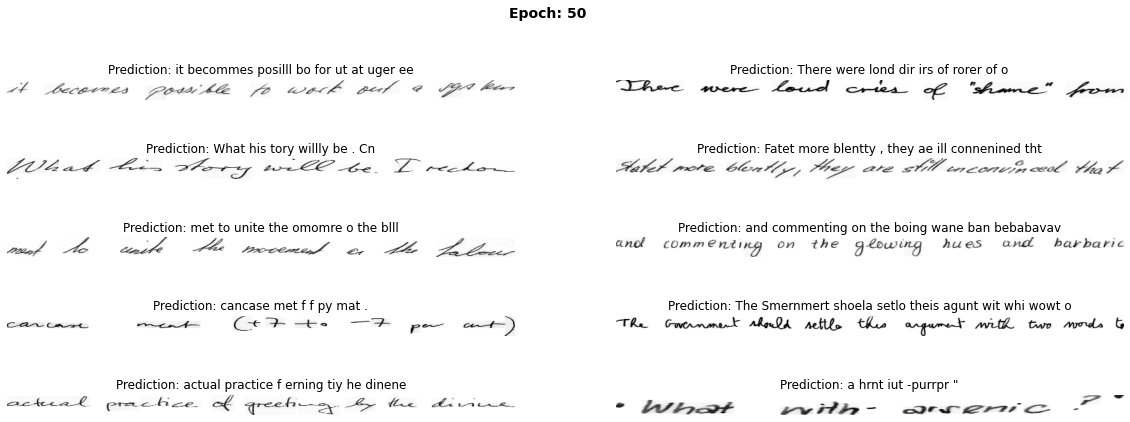

Epoch 52/350
107/107 [==============================] - 78s 685ms/step - loss: 40.8041 - val_loss: 68.0688

Epoch 00052: val_loss did not improve from 66.26599
Epoch 53/350
107/107 [==============================] - 78s 684ms/step - loss: 39.2533 - val_loss: 75.5351

Epoch 00053: val_loss did not improve from 66.26599
Epoch 54/350
107/107 [==============================] - 79s 687ms/step - loss: 40.3504 - val_loss: 66.8818

Epoch 00054: val_loss did not improve from 66.26599
Epoch 55/350
107/107 [==============================] - 78s 684ms/step - loss: 39.6574 - val_loss: 80.7867

Epoch 00055: val_loss did not improve from 66.26599
Epoch 56/350
107/107 [==============================] - 78s 684ms/step - loss: 39.3093 - val_loss: 68.8607

Epoch 00056: val_loss did not improve from 66.26599
Epoch 57/350
107/107 [==============================] - 78s 683ms/step - loss: 39.0803 - val_loss: 69.0179

Epoch 00057: val_loss did not improve from 66.26599
Epoch 58/350
107/107 [==================

<Figure size 432x288 with 0 Axes>

In [ ]:
# Entrainement
epochs = 350
history = model.fit(train_data, 
                    epochs = epochs,
                    validation_data=validation_data,
                    verbose = 1,
                    callbacks = callbacks_list,
                    shuffle=True
                   )

In [ ]:
history.history

Epoch 1/350
107/107 [==============================] - 3218s 30s/step - loss: 262.3283 - val_loss: 224.3491

Epoch 00001: val_loss improved from inf to 224.34908, saving model to /content/drive/My Drive/2lines_checkpoint.hdf5


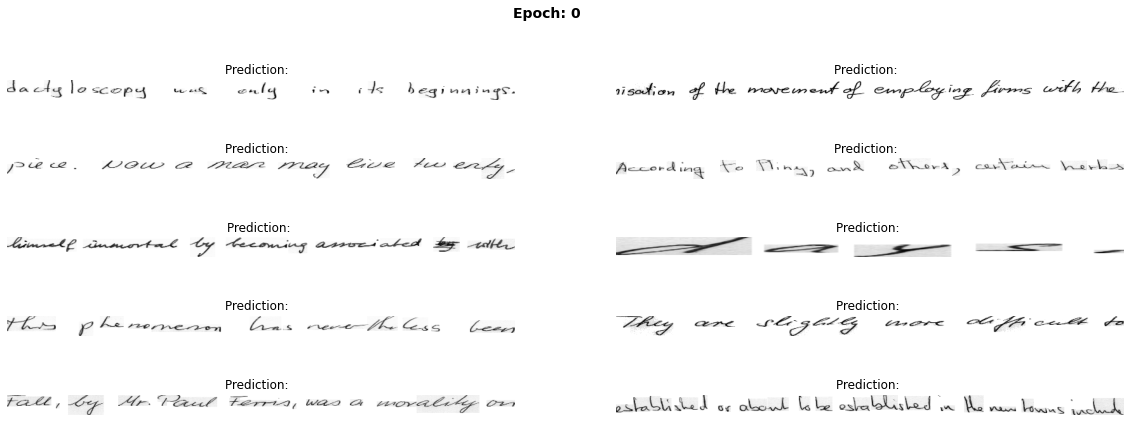

Epoch 2/350
107/107 [==============================] - 89s 787ms/step - loss: 154.0436 - val_loss: 392.6707

Epoch 00002: val_loss did not improve from 224.34908
Epoch 3/350
107/107 [==============================] - 89s 785ms/step - loss: 152.0132 - val_loss: 216.3629

Epoch 00003: val_loss improved from 224.34908 to 216.36295, saving model to /content/drive/My Drive/2lines_checkpoint.hdf5
Epoch 4/350
107/107 [==============================] - 90s 788ms/step - loss: 149.6117 - val_loss: 148.8932

Epoch 00004: val_loss improved from 216.36295 to 148.89317, saving model to /content/drive/My Drive/2lines_checkpoint.hdf5
Epoch 5/350
107/107 [==============================] - 90s 795ms/step - loss: 137.0344 - val_loss: 624.4676

Epoch 00005: val_loss did not improve from 148.89317
Epoch 6/350
107/107 [==============================] - 90s 791ms/step - loss: 134.9223 - val_loss: 138.0006

Epoch 00006: val_loss improved from 148.89317 to 138.00063, saving model to /content/drive/My Drive/2li

<Figure size 432x288 with 0 Axes>

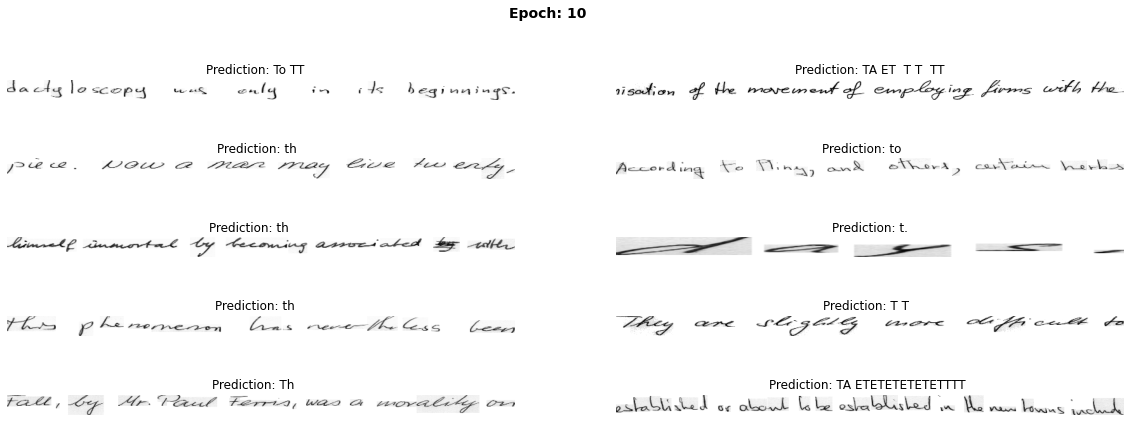

Epoch 12/350
107/107 [==============================] - 89s 778ms/step - loss: 127.5503 - val_loss: 214.4667

Epoch 00012: val_loss did not improve from 138.00063
Epoch 13/350
107/107 [==============================] - 89s 786ms/step - loss: 126.5653 - val_loss: 145.6019

Epoch 00013: val_loss did not improve from 138.00063
Epoch 14/350
107/107 [==============================] - 89s 786ms/step - loss: 126.4106 - val_loss: 492.6941

Epoch 00014: val_loss did not improve from 138.00063
Epoch 15/350
107/107 [==============================] - 89s 789ms/step - loss: 126.3376 - val_loss: 134.5915

Epoch 00015: val_loss improved from 138.00063 to 134.59151, saving model to /content/drive/My Drive/2lines_checkpoint.hdf5
Epoch 16/350
107/107 [==============================] - 89s 780ms/step - loss: 125.8321 - val_loss: 297.3479

Epoch 00016: val_loss did not improve from 134.59151
Epoch 17/350
107/107 [==============================] - 90s 793ms/step - loss: 124.3644 - val_loss: 437.2021

Epoch

<Figure size 432x288 with 0 Axes>

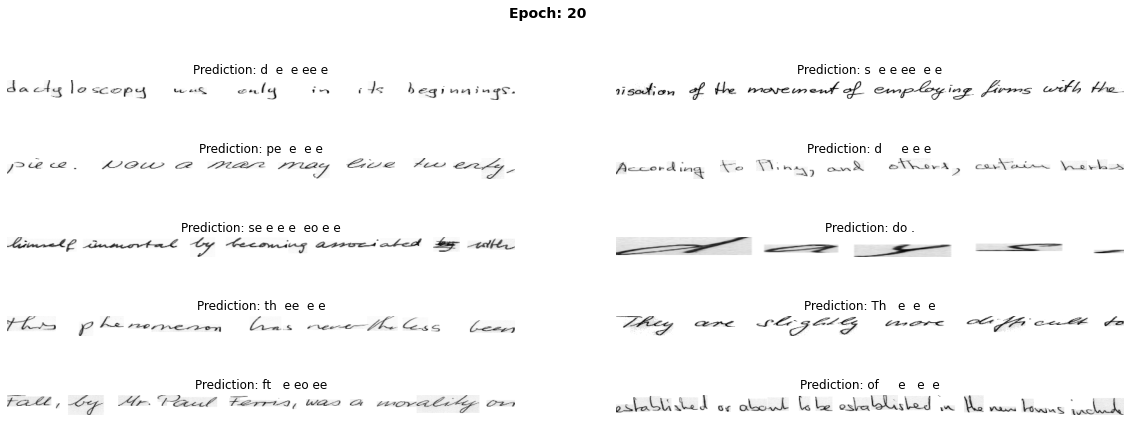

Epoch 22/350
107/107 [==============================] - 89s 787ms/step - loss: 122.3176 - val_loss: 137.1613

Epoch 00022: val_loss did not improve from 133.35962
Epoch 23/350
107/107 [==============================] - 89s 785ms/step - loss: 121.7190 - val_loss: 147.8514

Epoch 00023: val_loss did not improve from 133.35962
Epoch 24/350
107/107 [==============================] - 90s 791ms/step - loss: 120.9028 - val_loss: 187.8901

Epoch 00024: val_loss did not improve from 133.35962
Epoch 25/350
107/107 [==============================] - 89s 786ms/step - loss: 120.3840 - val_loss: 136.5092

Epoch 00025: val_loss did not improve from 133.35962
Epoch 26/350
107/107 [==============================] - 89s 786ms/step - loss: 120.0100 - val_loss: 150.1396

Epoch 00026: val_loss did not improve from 133.35962
Epoch 27/350
107/107 [==============================] - 89s 784ms/step - loss: 118.7198 - val_loss: 129.9513

Epoch 00027: val_loss improved from 133.35962 to 129.95126, saving model to

<Figure size 432x288 with 0 Axes>

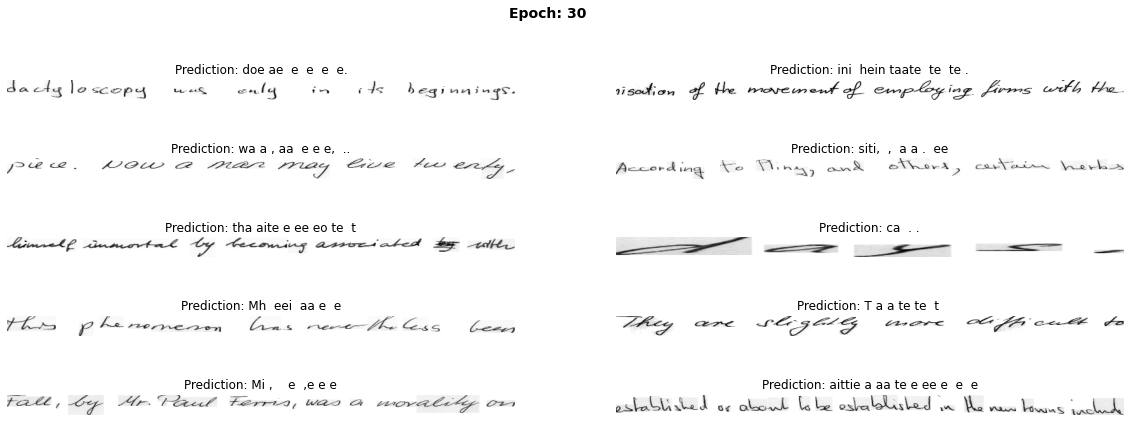

Epoch 32/350
107/107 [==============================] - 90s 792ms/step - loss: 114.8232 - val_loss: 122.8952

Epoch 00032: val_loss did not improve from 118.38445
Epoch 33/350
107/107 [==============================] - 89s 788ms/step - loss: 113.7785 - val_loss: 116.1375

Epoch 00033: val_loss improved from 118.38445 to 116.13754, saving model to /content/drive/My Drive/2lines_checkpoint.hdf5
Epoch 34/350
107/107 [==============================] - 90s 789ms/step - loss: 113.6302 - val_loss: 126.0704

Epoch 00034: val_loss did not improve from 116.13754
Epoch 35/350
107/107 [==============================] - 90s 792ms/step - loss: 112.7778 - val_loss: 136.0611

Epoch 00035: val_loss did not improve from 116.13754
Epoch 36/350
107/107 [==============================] - 90s 796ms/step - loss: 112.6015 - val_loss: 227.9139

Epoch 00036: val_loss did not improve from 116.13754
Epoch 37/350
107/107 [==============================] - 90s 789ms/step - loss: 111.0329 - val_loss: 115.3762

Epoch

<Figure size 432x288 with 0 Axes>

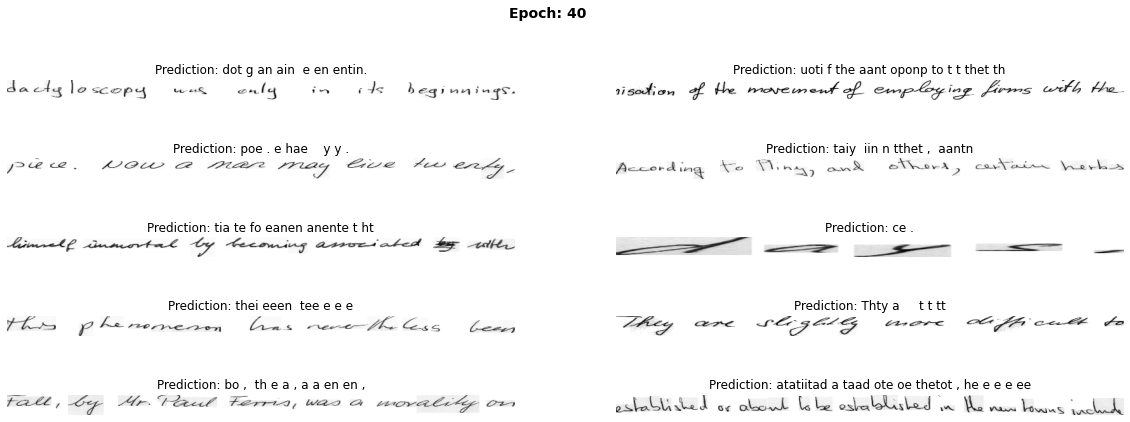

Epoch 42/350
107/107 [==============================] - 89s 780ms/step - loss: 107.1365 - val_loss: 136.9316

Epoch 00042: val_loss did not improve from 109.17673
Epoch 43/350
107/107 [==============================] - 90s 795ms/step - loss: 105.7504 - val_loss: 107.1346

Epoch 00043: val_loss improved from 109.17673 to 107.13456, saving model to /content/drive/My Drive/2lines_checkpoint.hdf5
Epoch 44/350
107/107 [==============================] - 90s 791ms/step - loss: 103.7296 - val_loss: 107.9376

Epoch 00044: val_loss did not improve from 107.13456
Epoch 45/350
107/107 [==============================] - 90s 792ms/step - loss: 104.1863 - val_loss: 117.0458

Epoch 00045: val_loss did not improve from 107.13456
Epoch 46/350
107/107 [==============================] - 90s 794ms/step - loss: 102.1648 - val_loss: 106.0022

Epoch 00046: val_loss improved from 107.13456 to 106.00224, saving model to /content/drive/My Drive/2lines_checkpoint.hdf5
Epoch 47/350
107/107 [=======================

<Figure size 432x288 with 0 Axes>

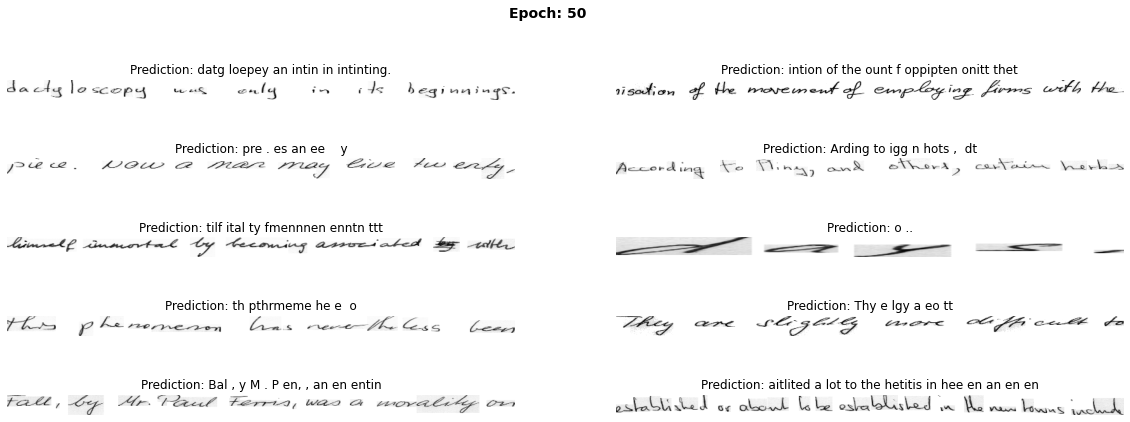

Epoch 52/350
107/107 [==============================] - 89s 784ms/step - loss: 96.5091 - val_loss: 128.4528

Epoch 00052: val_loss did not improve from 102.43585
Epoch 53/350
107/107 [==============================] - 89s 788ms/step - loss: 95.3443 - val_loss: 106.2611

Epoch 00053: val_loss did not improve from 102.43585
Epoch 54/350
107/107 [==============================] - 89s 786ms/step - loss: 93.9363 - val_loss: 96.5900

Epoch 00054: val_loss improved from 102.43585 to 96.58995, saving model to /content/drive/My Drive/2lines_checkpoint.hdf5
Epoch 55/350
107/107 [==============================] - 90s 787ms/step - loss: 93.0822 - val_loss: 106.8861

Epoch 00055: val_loss did not improve from 96.58995
Epoch 56/350
107/107 [==============================] - 89s 784ms/step - loss: 93.0114 - val_loss: 101.9799

Epoch 00056: val_loss did not improve from 96.58995
Epoch 57/350
107/107 [==============================] - 89s 784ms/step - loss: 94.2915 - val_loss: 99.3157

Epoch 00057: val

<Figure size 432x288 with 0 Axes>

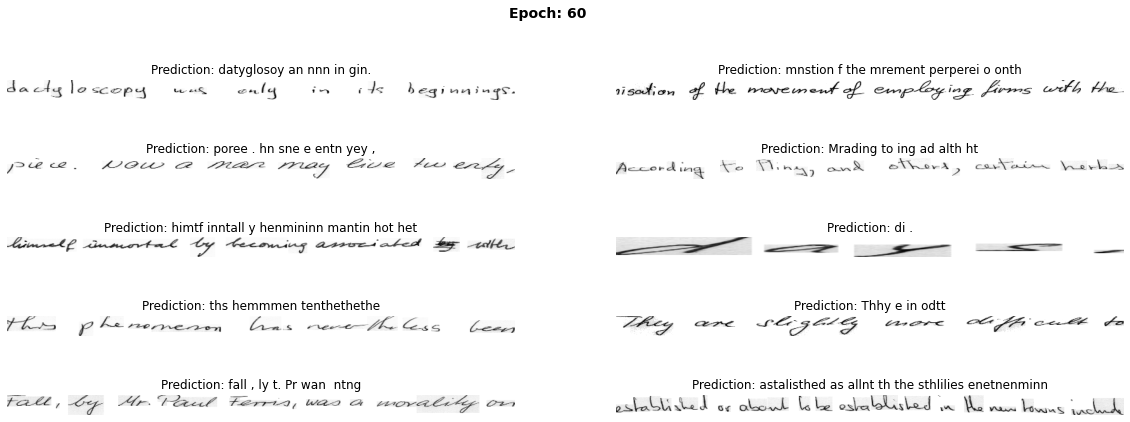

Epoch 62/350
107/107 [==============================] - 88s 778ms/step - loss: 93.3760 - val_loss: 96.5056

Epoch 00062: val_loss did not improve from 94.08712
Epoch 63/350
107/107 [==============================] - 89s 783ms/step - loss: 87.8994 - val_loss: 95.8925

Epoch 00063: val_loss did not improve from 94.08712
Epoch 64/350
107/107 [==============================] - 89s 787ms/step - loss: 87.3687 - val_loss: 92.6469

Epoch 00064: val_loss improved from 94.08712 to 92.64690, saving model to /content/drive/My Drive/2lines_checkpoint.hdf5
Epoch 65/350
107/107 [==============================] - 89s 786ms/step - loss: 90.3853 - val_loss: 91.1421

Epoch 00065: val_loss improved from 92.64690 to 91.14206, saving model to /content/drive/My Drive/2lines_checkpoint.hdf5
Epoch 66/350
107/107 [==============================] - 89s 786ms/step - loss: 87.6477 - val_loss: 94.0667

Epoch 00066: val_loss did not improve from 91.14206
Epoch 67/350
107/107 [==============================] - 90s 79

<Figure size 432x288 with 0 Axes>

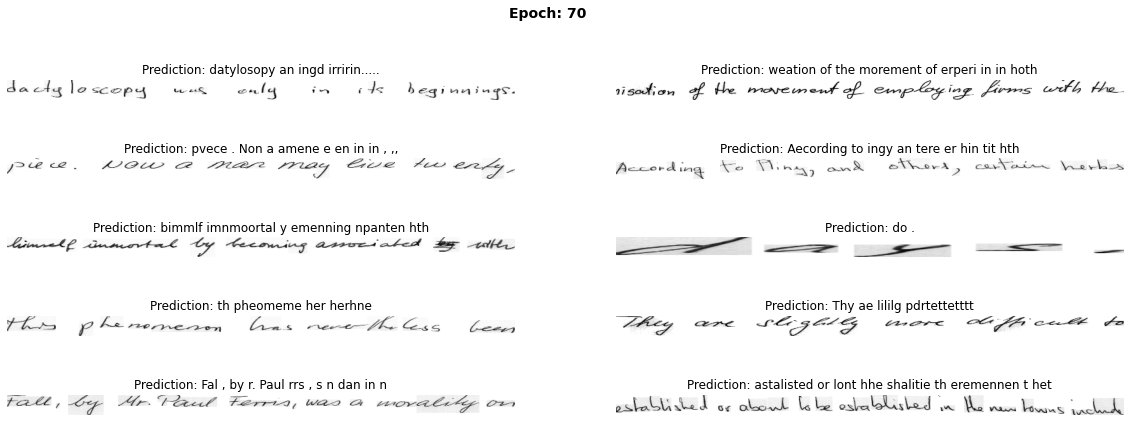

Epoch 72/350
107/107 [==============================] - 89s 782ms/step - loss: 84.2182 - val_loss: 88.6916

Epoch 00072: val_loss improved from 89.07400 to 88.69156, saving model to /content/drive/My Drive/2lines_checkpoint.hdf5
Epoch 73/350
107/107 [==============================] - 89s 783ms/step - loss: 83.7333 - val_loss: 93.2394

Epoch 00073: val_loss did not improve from 88.69156
Epoch 74/350
107/107 [==============================] - 89s 789ms/step - loss: 83.5859 - val_loss: 164.1555

Epoch 00074: val_loss did not improve from 88.69156
Epoch 75/350
107/107 [==============================] - 89s 785ms/step - loss: 88.9725 - val_loss: 95.0623

Epoch 00075: val_loss did not improve from 88.69156
Epoch 76/350
107/107 [==============================] - 89s 783ms/step - loss: 88.8411 - val_loss: 88.1869

Epoch 00076: val_loss improved from 88.69156 to 88.18688, saving model to /content/drive/My Drive/2lines_checkpoint.hdf5
Epoch 77/350
107/107 [==============================] - 89s 7

<Figure size 432x288 with 0 Axes>

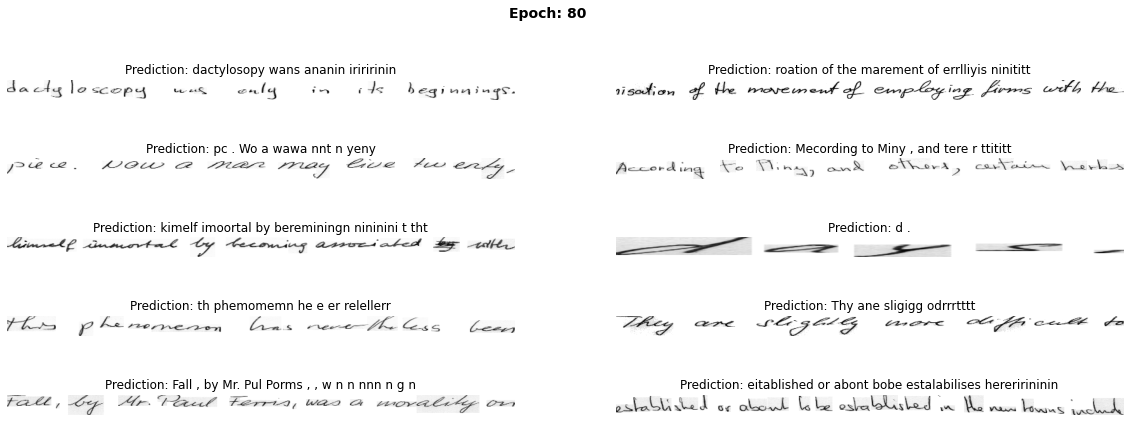

Epoch 82/350
107/107 [==============================] - 89s 781ms/step - loss: 85.0759 - val_loss: 86.9747

Epoch 00082: val_loss did not improve from 85.83089
Epoch 83/350
107/107 [==============================] - 89s 789ms/step - loss: 83.7271 - val_loss: 95.8008

Epoch 00083: val_loss did not improve from 85.83089
Epoch 84/350
107/107 [==============================] - 90s 791ms/step - loss: 83.9578 - val_loss: 95.6693

Epoch 00084: val_loss did not improve from 85.83089
Epoch 85/350
107/107 [==============================] - 89s 787ms/step - loss: 82.0519 - val_loss: 89.9122

Epoch 00085: val_loss did not improve from 85.83089
Epoch 86/350
107/107 [==============================] - 89s 785ms/step - loss: 84.5093 - val_loss: 87.5998

Epoch 00086: val_loss did not improve from 85.83089
Epoch 87/350
107/107 [==============================] - 90s 791ms/step - loss: 83.4988 - val_loss: 89.9596

Epoch 00087: val_loss did not improve from 85.83089
Epoch 88/350
107/107 [==================

<Figure size 432x288 with 0 Axes>

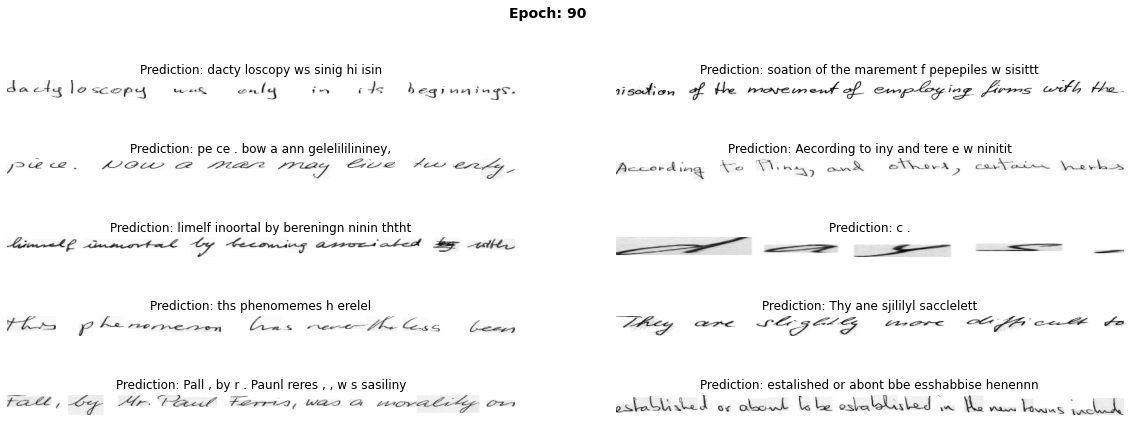

Epoch 92/350
107/107 [==============================] - 89s 783ms/step - loss: 79.2669 - val_loss: 120.6585

Epoch 00092: val_loss did not improve from 84.15016
Epoch 93/350
107/107 [==============================] - 89s 786ms/step - loss: 81.5788 - val_loss: 83.6054

Epoch 00093: val_loss improved from 84.15016 to 83.60542, saving model to /content/drive/My Drive/2lines_checkpoint.hdf5
Epoch 94/350
107/107 [==============================] - 90s 789ms/step - loss: 76.4752 - val_loss: 83.4080

Epoch 00094: val_loss improved from 83.60542 to 83.40804, saving model to /content/drive/My Drive/2lines_checkpoint.hdf5
Epoch 95/350
107/107 [==============================] - 90s 788ms/step - loss: 76.0242 - val_loss: 83.2005

Epoch 00095: val_loss improved from 83.40804 to 83.20051, saving model to /content/drive/My Drive/2lines_checkpoint.hdf5
Epoch 96/350
107/107 [==============================] - 90s 788ms/step - loss: 74.2267 - val_loss: 90.5324

Epoch 00096: val_loss did not improve from 8

<Figure size 432x288 with 0 Axes>

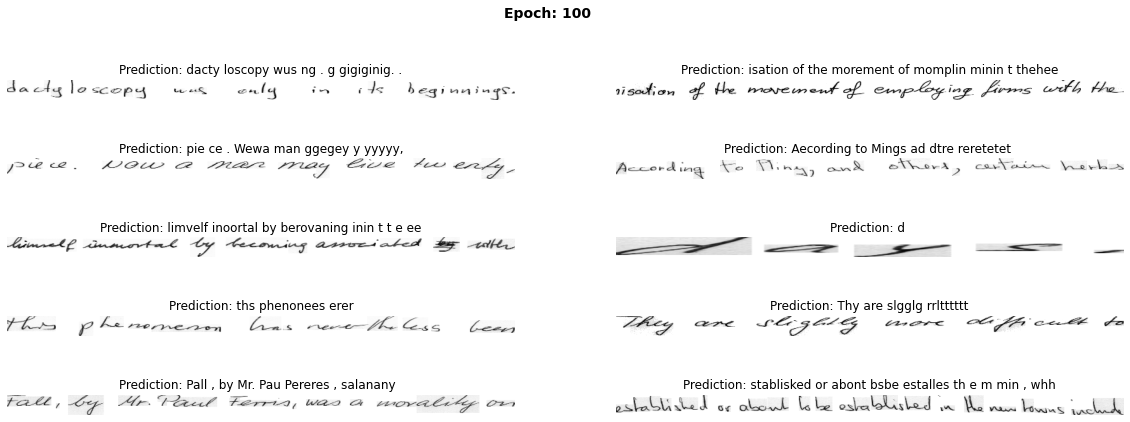

Epoch 102/350
107/107 [==============================] - 90s 794ms/step - loss: 74.6519 - val_loss: 85.5216

Epoch 00102: val_loss did not improve from 82.59161
Epoch 103/350
107/107 [==============================] - 92s 806ms/step - loss: 76.7019 - val_loss: 83.1347

Epoch 00103: val_loss did not improve from 82.59161
Epoch 104/350
107/107 [==============================] - 90s 796ms/step - loss: 72.9957 - val_loss: 84.4440

Epoch 00104: val_loss did not improve from 82.59161
Epoch 105/350
107/107 [==============================] - 91s 803ms/step - loss: 73.3975 - val_loss: 97.1433

Epoch 00105: val_loss did not improve from 82.59161
Epoch 106/350
107/107 [==============================] - 90s 796ms/step - loss: 72.4143 - val_loss: 106.9183

Epoch 00106: val_loss did not improve from 82.59161
Epoch 107/350
107/107 [==============================] - 90s 798ms/step - loss: 73.4466 - val_loss: 79.9235

Epoch 00107: val_loss improved from 82.59161 to 79.92347, saving model to /content/dr

<Figure size 432x288 with 0 Axes>

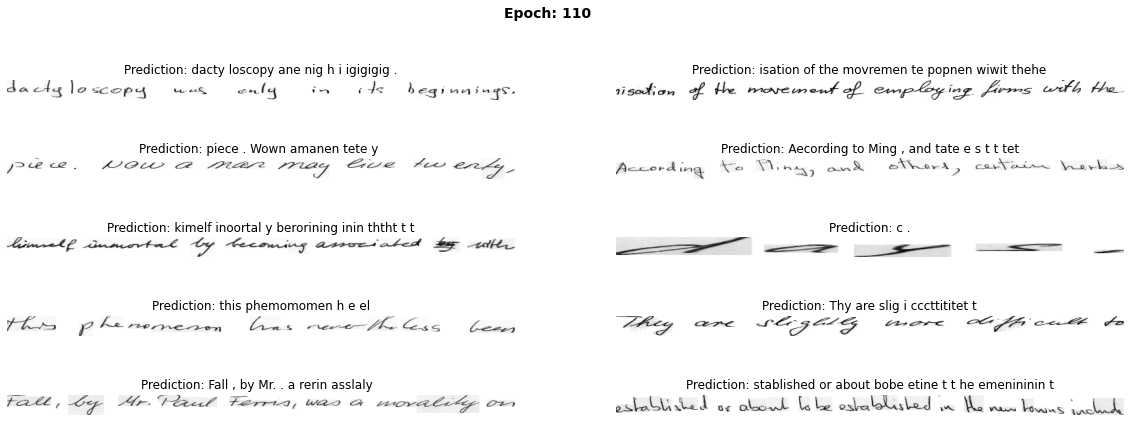

Epoch 112/350
107/107 [==============================] - 90s 788ms/step - loss: 74.2344 - val_loss: 83.6867

Epoch 00112: val_loss did not improve from 79.92347
Epoch 113/350
107/107 [==============================] - 89s 786ms/step - loss: 72.9413 - val_loss: 85.5126

Epoch 00113: val_loss did not improve from 79.92347
Epoch 114/350
107/107 [==============================] - 89s 783ms/step - loss: 71.8807 - val_loss: 97.0230

Epoch 00114: val_loss did not improve from 79.92347
Epoch 115/350
107/107 [==============================] - 89s 788ms/step - loss: 77.9096 - val_loss: 89.4176

Epoch 00115: val_loss did not improve from 79.92347
Epoch 116/350
107/107 [==============================] - 89s 782ms/step - loss: 70.4641 - val_loss: 81.6178

Epoch 00116: val_loss did not improve from 79.92347
Epoch 117/350
107/107 [==============================] - 89s 786ms/step - loss: 73.1933 - val_loss: 127.6200

Epoch 00117: val_loss did not improve from 79.92347
Epoch 118/350
107/107 [==========

<Figure size 432x288 with 0 Axes>

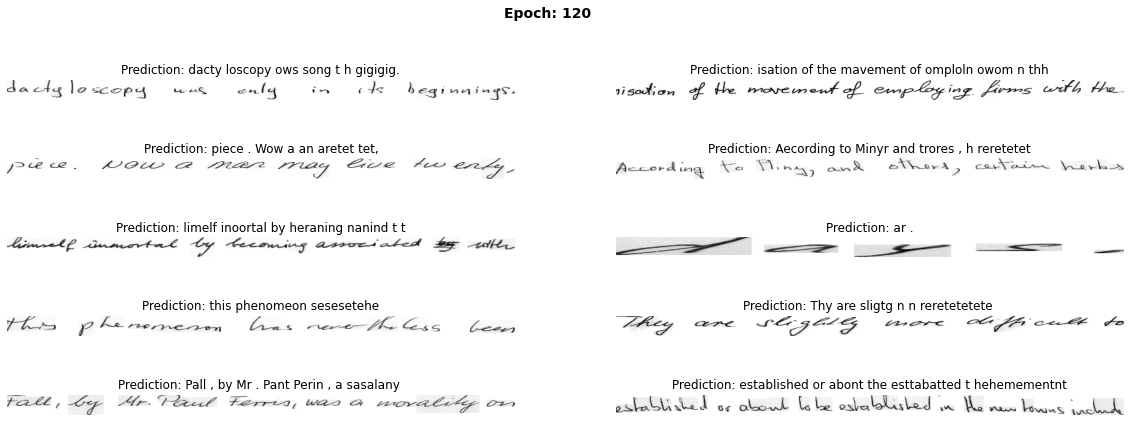

Epoch 122/350
107/107 [==============================] - 89s 781ms/step - loss: 68.8377 - val_loss: 136.4816

Epoch 00122: val_loss did not improve from 79.70855
Epoch 123/350
107/107 [==============================] - 89s 785ms/step - loss: 71.2830 - val_loss: 78.6468

Epoch 00123: val_loss improved from 79.70855 to 78.64682, saving model to /content/drive/My Drive/2lines_checkpoint.hdf5
Epoch 124/350
107/107 [==============================] - 89s 784ms/step - loss: 68.1232 - val_loss: 79.1501

Epoch 00124: val_loss did not improve from 78.64682
Epoch 125/350
107/107 [==============================] - 90s 791ms/step - loss: 69.7389 - val_loss: 81.5531

Epoch 00125: val_loss did not improve from 78.64682
Epoch 126/350
107/107 [==============================] - 89s 781ms/step - loss: 67.2225 - val_loss: 77.6176

Epoch 00126: val_loss improved from 78.64682 to 77.61756, saving model to /content/drive/My Drive/2lines_checkpoint.hdf5
Epoch 127/350
107/107 [==============================] -

<Figure size 432x288 with 0 Axes>

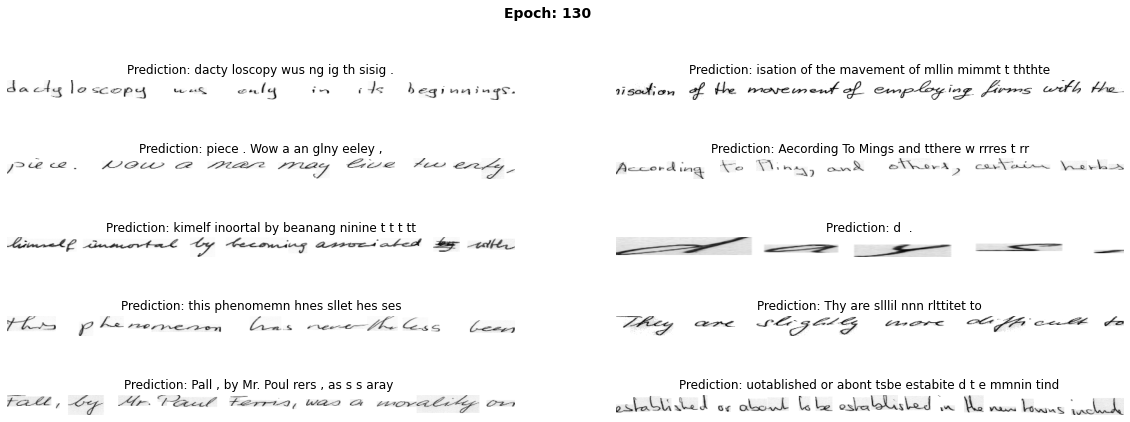

Epoch 132/350
107/107 [==============================] - 89s 784ms/step - loss: 69.0607 - val_loss: 81.4155

Epoch 00132: val_loss did not improve from 77.61756
Epoch 133/350
107/107 [==============================] - 89s 788ms/step - loss: 68.3139 - val_loss: 78.4755

Epoch 00133: val_loss did not improve from 77.61756
Epoch 134/350
107/107 [==============================] - 89s 786ms/step - loss: 68.6245 - val_loss: 78.3503

Epoch 00134: val_loss did not improve from 77.61756
Epoch 135/350
107/107 [==============================] - 89s 783ms/step - loss: 66.7965 - val_loss: 79.4462

Epoch 00135: val_loss did not improve from 77.61756
Epoch 136/350
107/107 [==============================] - 90s 794ms/step - loss: 66.7179 - val_loss: 77.0265

Epoch 00136: val_loss improved from 77.61756 to 77.02654, saving model to /content/drive/My Drive/2lines_checkpoint.hdf5
Epoch 137/350
107/107 [==============================] - 89s 786ms/step - loss: 68.0622 - val_loss: 85.6571

Epoch 00137: val_

<Figure size 432x288 with 0 Axes>

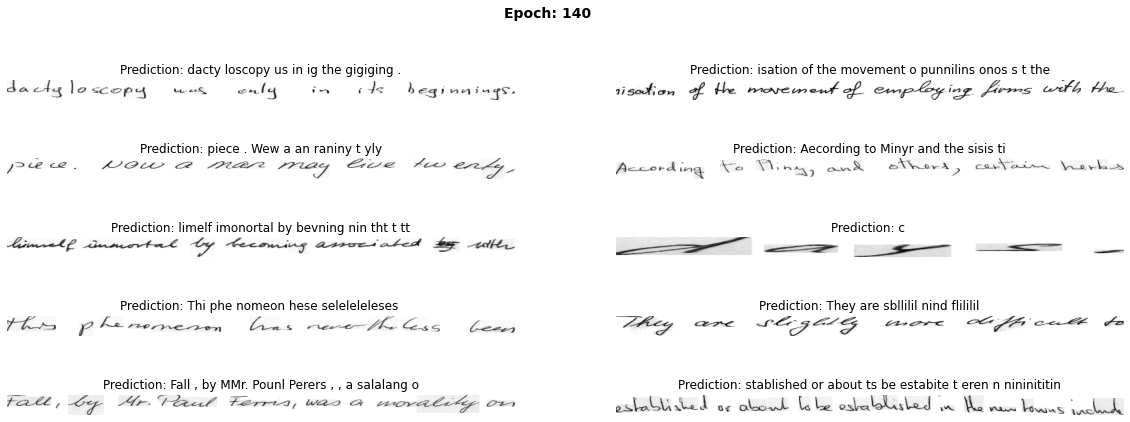

Epoch 142/350
107/107 [==============================] - 89s 781ms/step - loss: 68.6849 - val_loss: 82.9614

Epoch 00142: val_loss did not improve from 77.02654
Epoch 143/350
107/107 [==============================] - 89s 783ms/step - loss: 66.9079 - val_loss: 81.6986

Epoch 00143: val_loss did not improve from 77.02654
Epoch 144/350
107/107 [==============================] - 89s 781ms/step - loss: 64.7433 - val_loss: 82.2094

Epoch 00144: val_loss did not improve from 77.02654
Epoch 145/350
107/107 [==============================] - 88s 778ms/step - loss: 65.9613 - val_loss: 84.7208

Epoch 00145: val_loss did not improve from 77.02654
Epoch 146/350
107/107 [==============================] - 89s 785ms/step - loss: 63.4917 - val_loss: 78.2170

Epoch 00146: val_loss did not improve from 77.02654
Epoch 147/350
107/107 [==============================] - 89s 784ms/step - loss: 63.9308 - val_loss: 77.2533

Epoch 00147: val_loss did not improve from 77.02654
Epoch 148/350
107/107 [===========

<Figure size 432x288 with 0 Axes>

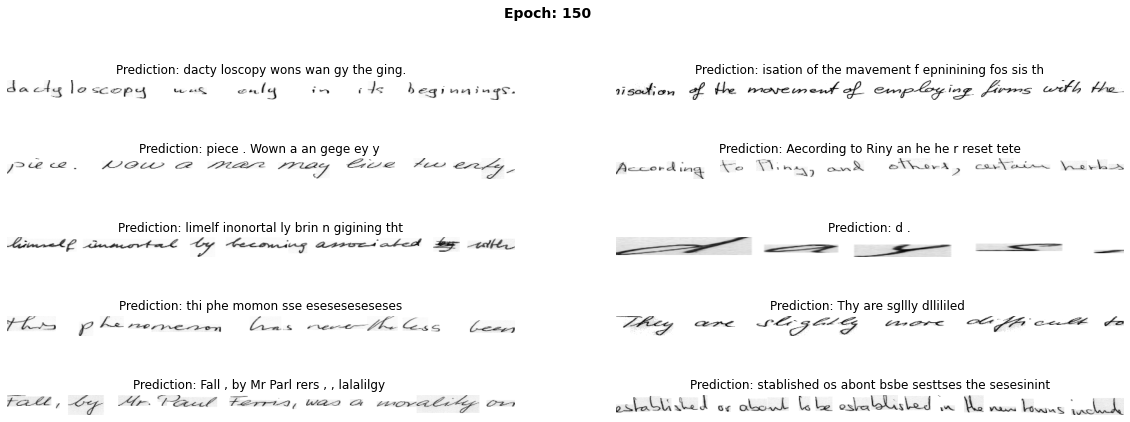

Epoch 152/350
107/107 [==============================] - 88s 774ms/step - loss: 66.1783 - val_loss: 77.1786

Epoch 00152: val_loss did not improve from 77.02654
Epoch 153/350
107/107 [==============================] - 89s 789ms/step - loss: 66.8888 - val_loss: 120.6516

Epoch 00153: val_loss did not improve from 77.02654
Epoch 154/350
107/107 [==============================] - 89s 788ms/step - loss: 66.1204 - val_loss: 76.3613

Epoch 00154: val_loss improved from 77.02654 to 76.36131, saving model to /content/drive/My Drive/2lines_checkpoint.hdf5
Epoch 155/350
107/107 [==============================] - 90s 790ms/step - loss: 63.1635 - val_loss: 78.3931

Epoch 00155: val_loss did not improve from 76.36131
Epoch 156/350
107/107 [==============================] - 89s 789ms/step - loss: 62.7827 - val_loss: 79.7023

Epoch 00156: val_loss did not improve from 76.36131
Epoch 157/350
107/107 [==============================] - 90s 791ms/step - loss: 63.5755 - val_loss: 82.3123

Epoch 00157: val

<Figure size 432x288 with 0 Axes>

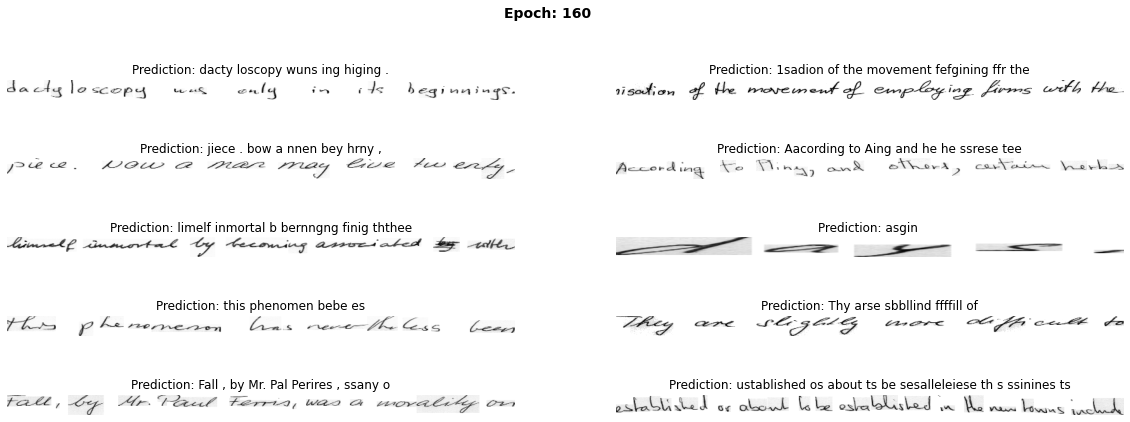

Epoch 162/350
107/107 [==============================] - 90s 790ms/step - loss: 68.5260 - val_loss: 77.6396

Epoch 00162: val_loss did not improve from 76.13003
Epoch 163/350
107/107 [==============================] - 88s 778ms/step - loss: 63.0807 - val_loss: 88.3600

Epoch 00163: val_loss did not improve from 76.13003
Epoch 164/350
107/107 [==============================] - 89s 783ms/step - loss: 65.6211 - val_loss: 80.6528

Epoch 00164: val_loss did not improve from 76.13003
Epoch 165/350
107/107 [==============================] - 89s 784ms/step - loss: 63.8445 - val_loss: 84.4216

Epoch 00165: val_loss did not improve from 76.13003
Epoch 166/350
107/107 [==============================] - 89s 783ms/step - loss: 61.0337 - val_loss: 76.5218

Epoch 00166: val_loss did not improve from 76.13003
Epoch 167/350
107/107 [==============================] - 89s 787ms/step - loss: 61.5454 - val_loss: 76.6180

Epoch 00167: val_loss did not improve from 76.13003
Epoch 168/350
107/107 [===========

<Figure size 432x288 with 0 Axes>

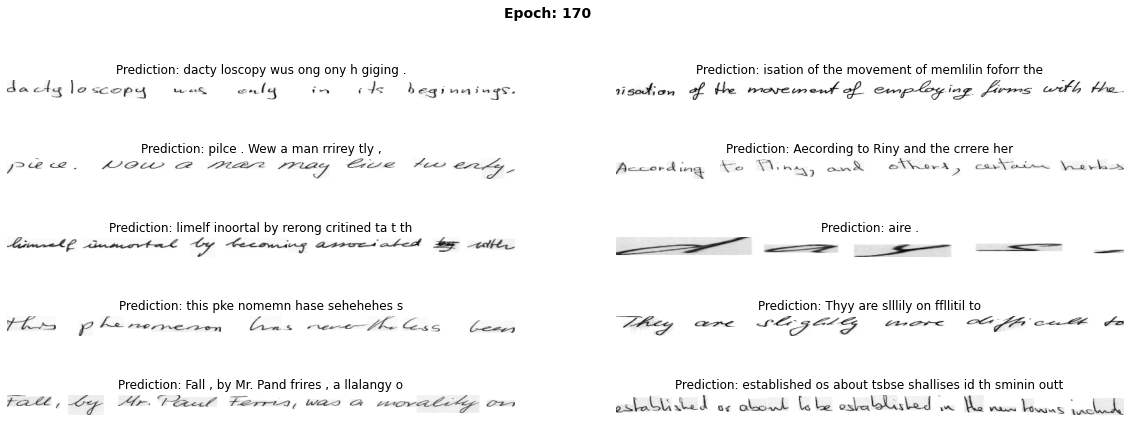

Epoch 172/350
107/107 [==============================] - 90s 793ms/step - loss: 59.0632 - val_loss: 79.3126

Epoch 00172: val_loss did not improve from 74.93573
Epoch 173/350
107/107 [==============================] - 91s 799ms/step - loss: 57.9756 - val_loss: 74.3312

Epoch 00173: val_loss improved from 74.93573 to 74.33122, saving model to /content/drive/My Drive/2lines_checkpoint.hdf5
Epoch 174/350
107/107 [==============================] - 91s 805ms/step - loss: 57.9402 - val_loss: 73.9703

Epoch 00174: val_loss improved from 74.33122 to 73.97029, saving model to /content/drive/My Drive/2lines_checkpoint.hdf5
Epoch 175/350
107/107 [==============================] - 91s 799ms/step - loss: 57.3729 - val_loss: 84.2421

Epoch 00175: val_loss did not improve from 73.97029
Epoch 176/350
107/107 [==============================] - 90s 798ms/step - loss: 59.5184 - val_loss: 77.6702

Epoch 00176: val_loss did not improve from 73.97029
Epoch 177/350
107/107 [==============================] - 

<Figure size 432x288 with 0 Axes>

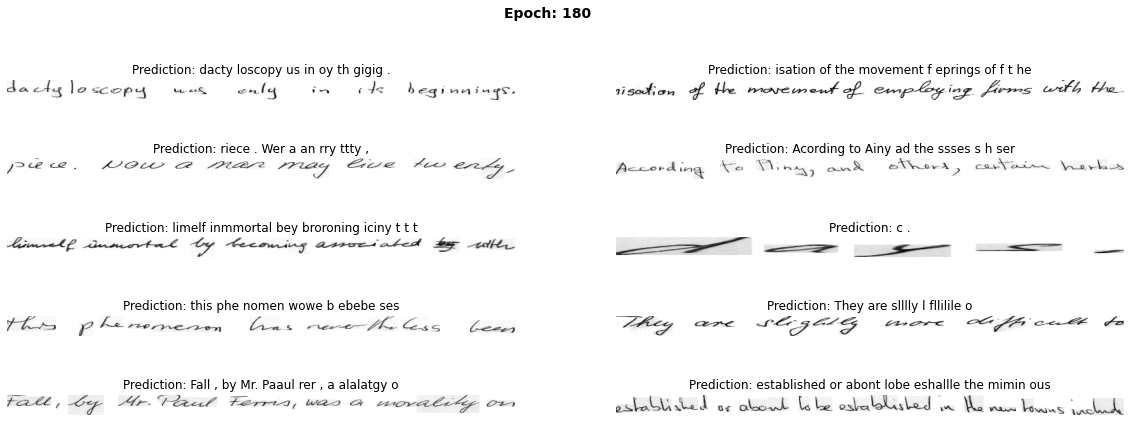

Epoch 182/350
107/107 [==============================] - 89s 783ms/step - loss: 60.5947 - val_loss: 74.8309

Epoch 00182: val_loss did not improve from 73.97029
Epoch 183/350
107/107 [==============================] - 88s 777ms/step - loss: 58.6314 - val_loss: 75.2395

Epoch 00183: val_loss did not improve from 73.97029
Epoch 184/350
107/107 [==============================] - 89s 783ms/step - loss: 58.2804 - val_loss: 83.7411

Epoch 00184: val_loss did not improve from 73.97029
Epoch 185/350
107/107 [==============================] - 89s 781ms/step - loss: 57.0228 - val_loss: 77.0851

Epoch 00185: val_loss did not improve from 73.97029
Epoch 186/350
107/107 [==============================] - 88s 779ms/step - loss: 58.6272 - val_loss: 74.2799

Epoch 00186: val_loss did not improve from 73.97029
Epoch 187/350
107/107 [==============================] - 89s 781ms/step - loss: 57.6807 - val_loss: 76.6007

Epoch 00187: val_loss did not improve from 73.97029
Epoch 188/350
107/107 [===========

<Figure size 432x288 with 0 Axes>

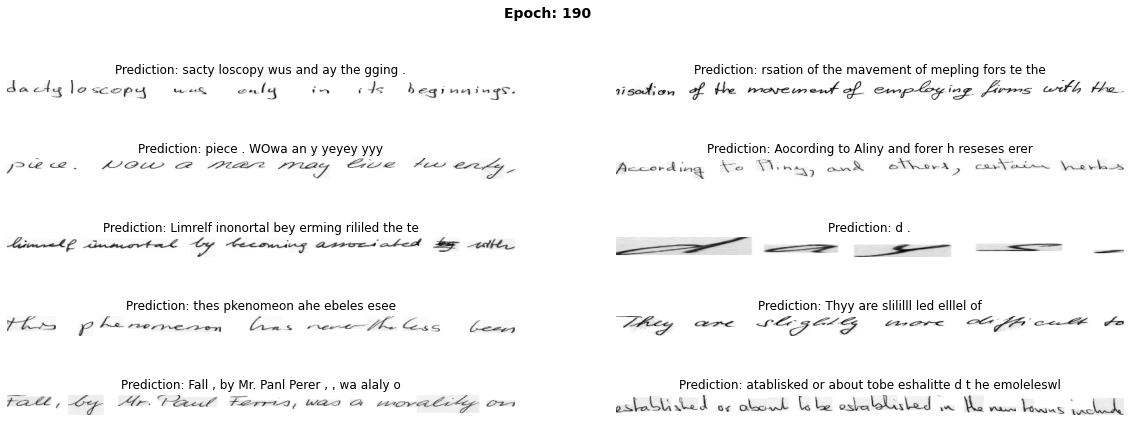

Epoch 192/350
107/107 [==============================] - 88s 777ms/step - loss: 57.2914 - val_loss: 76.3719

Epoch 00192: val_loss did not improve from 73.97029
Epoch 193/350
107/107 [==============================] - 88s 775ms/step - loss: 59.5551 - val_loss: 74.4479

Epoch 00193: val_loss did not improve from 73.97029
Epoch 194/350
107/107 [==============================] - 89s 783ms/step - loss: 57.7445 - val_loss: 78.5428

Epoch 00194: val_loss did not improve from 73.97029
Epoch 195/350
107/107 [==============================] - 89s 782ms/step - loss: 61.8141 - val_loss: 75.3463

Epoch 00195: val_loss did not improve from 73.97029
Epoch 196/350
107/107 [==============================] - 88s 779ms/step - loss: 57.4714 - val_loss: 76.0841

Epoch 00196: val_loss did not improve from 73.97029
Epoch 197/350
107/107 [==============================] - 89s 782ms/step - loss: 56.6643 - val_loss: 75.0208

Epoch 00197: val_loss did not improve from 73.97029
Epoch 198/350
107/107 [===========

<Figure size 432x288 with 0 Axes>

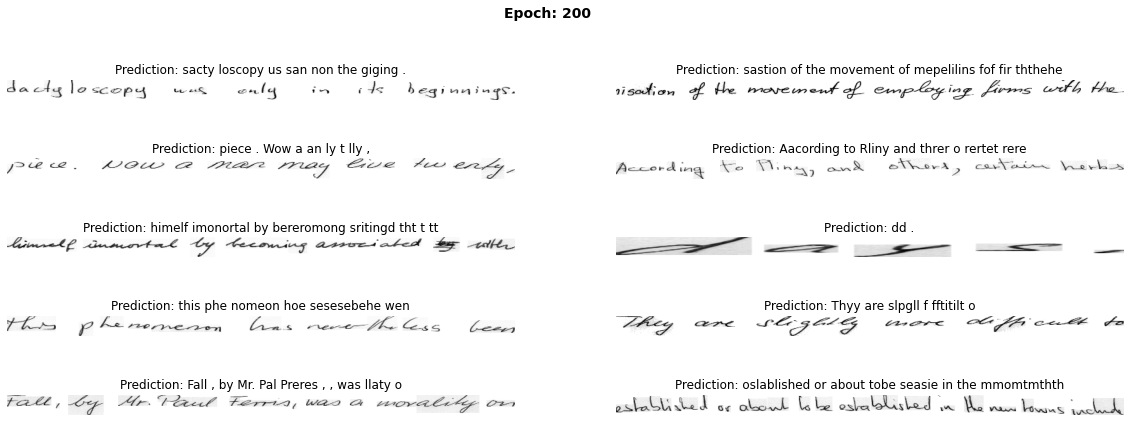

Epoch 202/350
107/107 [==============================] - 88s 774ms/step - loss: 59.6592 - val_loss: 77.6666

Epoch 00202: val_loss did not improve from 73.97029
Epoch 203/350
107/107 [==============================] - 88s 772ms/step - loss: 58.7366 - val_loss: 73.5699

Epoch 00203: val_loss improved from 73.97029 to 73.56988, saving model to /content/drive/My Drive/2lines_checkpoint.hdf5
Epoch 204/350
107/107 [==============================] - 89s 782ms/step - loss: 56.6726 - val_loss: 74.8343

Epoch 00204: val_loss did not improve from 73.56988
Epoch 205/350
107/107 [==============================] - 89s 787ms/step - loss: 56.6104 - val_loss: 76.7779

Epoch 00205: val_loss did not improve from 73.56988
Epoch 206/350
107/107 [==============================] - 89s 782ms/step - loss: 56.0039 - val_loss: 81.7481

Epoch 00206: val_loss did not improve from 73.56988
Epoch 207/350
107/107 [==============================] - 89s 782ms/step - loss: 55.0132 - val_loss: 77.3357

Epoch 00207: val_

<Figure size 432x288 with 0 Axes>

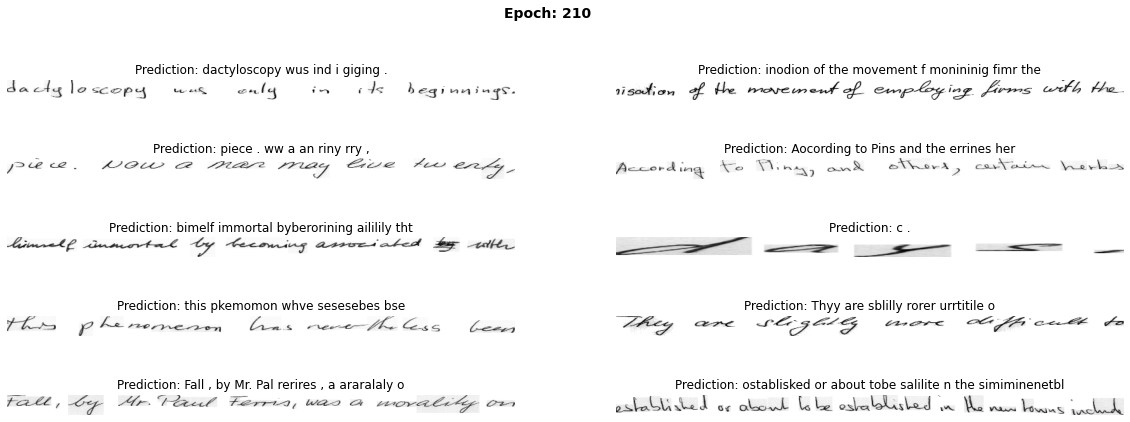

Epoch 212/350
107/107 [==============================] - 89s 780ms/step - loss: 55.0900 - val_loss: 74.6853

Epoch 00212: val_loss did not improve from 72.61904
Epoch 213/350
107/107 [==============================] - 88s 777ms/step - loss: 53.5253 - val_loss: 72.7827

Epoch 00213: val_loss did not improve from 72.61904
Epoch 214/350
107/107 [==============================] - 89s 779ms/step - loss: 53.5288 - val_loss: 84.9738

Epoch 00214: val_loss did not improve from 72.61904
Epoch 215/350
107/107 [==============================] - 88s 778ms/step - loss: 54.3740 - val_loss: 72.6456

Epoch 00215: val_loss did not improve from 72.61904
Epoch 216/350
107/107 [==============================] - 88s 775ms/step - loss: 56.3089 - val_loss: 73.6938

Epoch 00216: val_loss did not improve from 72.61904
Epoch 217/350
107/107 [==============================] - 88s 772ms/step - loss: 53.0268 - val_loss: 79.2137

Epoch 00217: val_loss did not improve from 72.61904
Epoch 218/350
107/107 [===========

<Figure size 432x288 with 0 Axes>

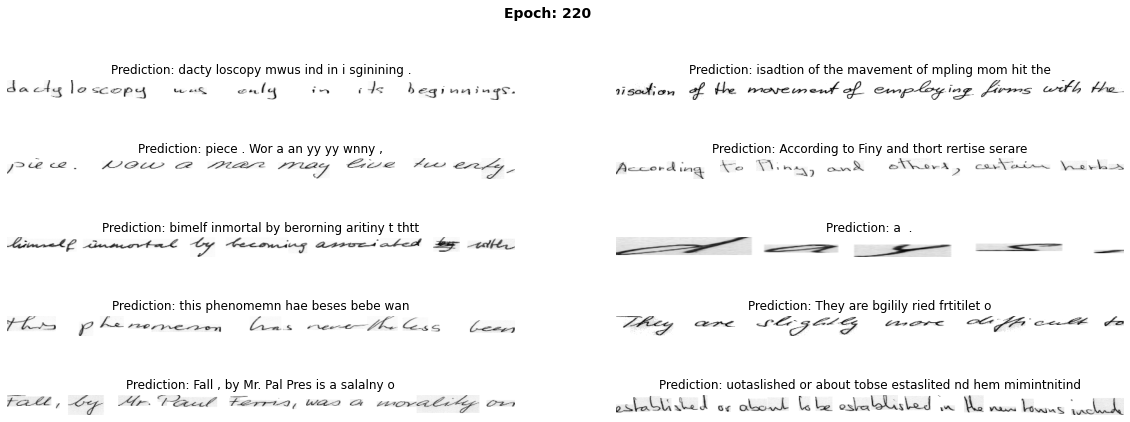

Epoch 222/350
107/107 [==============================] - 87s 768ms/step - loss: 51.7890 - val_loss: 73.7607

Epoch 00222: val_loss did not improve from 71.25481
Epoch 223/350
107/107 [==============================] - 89s 777ms/step - loss: 54.3152 - val_loss: 76.6329

Epoch 00223: val_loss did not improve from 71.25481
Epoch 224/350
107/107 [==============================] - 88s 777ms/step - loss: 51.9508 - val_loss: 71.3820

Epoch 00224: val_loss did not improve from 71.25481
Epoch 225/350
107/107 [==============================] - 89s 783ms/step - loss: 51.3220 - val_loss: 80.4516

Epoch 00225: val_loss did not improve from 71.25481
Epoch 226/350
107/107 [==============================] - 89s 787ms/step - loss: 51.4637 - val_loss: 78.1977

Epoch 00226: val_loss did not improve from 71.25481
Epoch 227/350
 76/107 [====================>.........] - ETA: 21s - loss: 52.4756

In [ ]:
# Entrainement
epochs = 350
history = model.fit(train_data, 
                    epochs = epochs,
                    validation_data=validation_data,
                    verbose = 1,
                    callbacks = callbacks_list,
                    shuffle=True
                   )

Epoch 1/250
107/107 [==============================] - 3314s 31s/step - loss: 255.9746 - val_loss: 603.4708

Epoch 00001: val_loss improved from inf to 603.47076, saving model to lines_checkpoint.hdf5


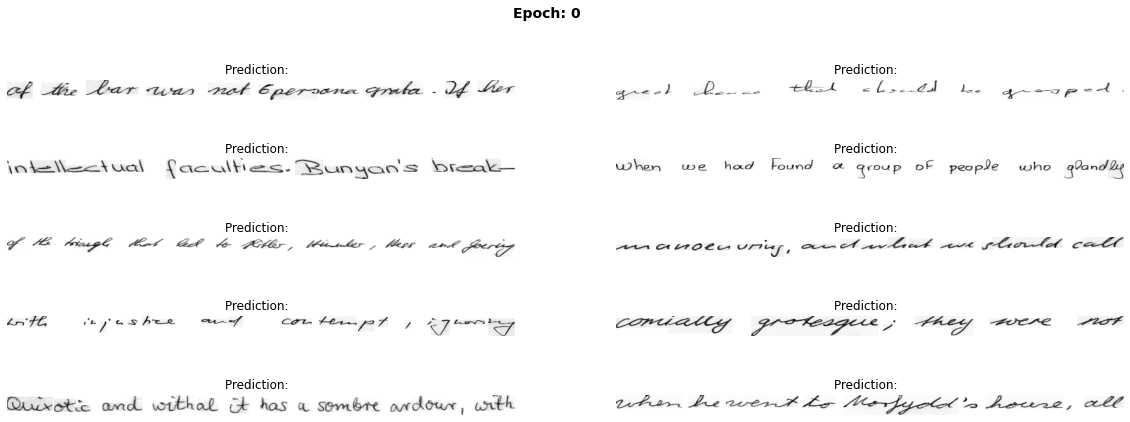

Epoch 2/250
107/107 [==============================] - 97s 852ms/step - loss: 157.0514 - val_loss: 474.5539

Epoch 00002: val_loss improved from 603.47076 to 474.55392, saving model to lines_checkpoint.hdf5
Epoch 3/250
107/107 [==============================] - 99s 864ms/step - loss: 152.6564 - val_loss: 155.3566

Epoch 00003: val_loss improved from 474.55392 to 155.35658, saving model to lines_checkpoint.hdf5
Epoch 4/250
107/107 [==============================] - 99s 866ms/step - loss: 152.4646 - val_loss: 167.6547

Epoch 00004: val_loss did not improve from 155.35658
Epoch 5/250
107/107 [==============================] - 99s 870ms/step - loss: 145.2246 - val_loss: 163.1878

Epoch 00005: val_loss did not improve from 155.35658
Epoch 6/250
107/107 [==============================] - 100s 881ms/step - loss: 136.9193 - val_loss: 475.6113

Epoch 00006: val_loss did not improve from 155.35658
Epoch 7/250
107/107 [==============================] - 98s 867ms/step - loss: 136.5051 - val_loss: 

<Figure size 432x288 with 0 Axes>

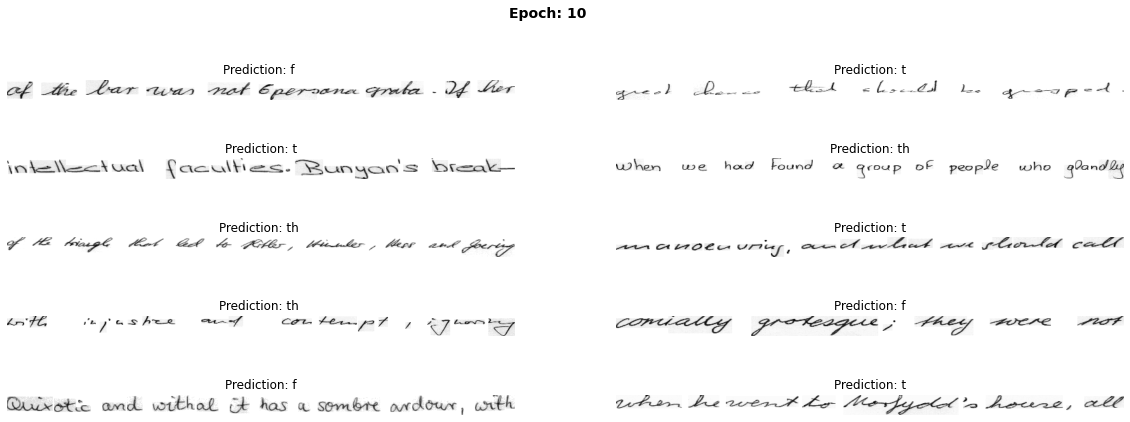

Epoch 12/250
107/107 [==============================] - 96s 845ms/step - loss: 131.2892 - val_loss: 136.7760

Epoch 00012: val_loss improved from 140.17288 to 136.77603, saving model to lines_checkpoint.hdf5
Epoch 13/250
107/107 [==============================] - 97s 856ms/step - loss: 129.0411 - val_loss: 569.4307

Epoch 00013: val_loss did not improve from 136.77603
Epoch 14/250
107/107 [==============================] - 98s 860ms/step - loss: 126.3316 - val_loss: 154.6672

Epoch 00014: val_loss did not improve from 136.77603
Epoch 15/250
107/107 [==============================] - 99s 867ms/step - loss: 126.4673 - val_loss: 135.9260

Epoch 00015: val_loss improved from 136.77603 to 135.92599, saving model to lines_checkpoint.hdf5
Epoch 16/250
107/107 [==============================] - 98s 857ms/step - loss: 125.5744 - val_loss: 301.7047

Epoch 00016: val_loss did not improve from 135.92599
Epoch 17/250
107/107 [==============================] - 97s 854ms/step - loss: 125.9486 - val_l

<Figure size 432x288 with 0 Axes>

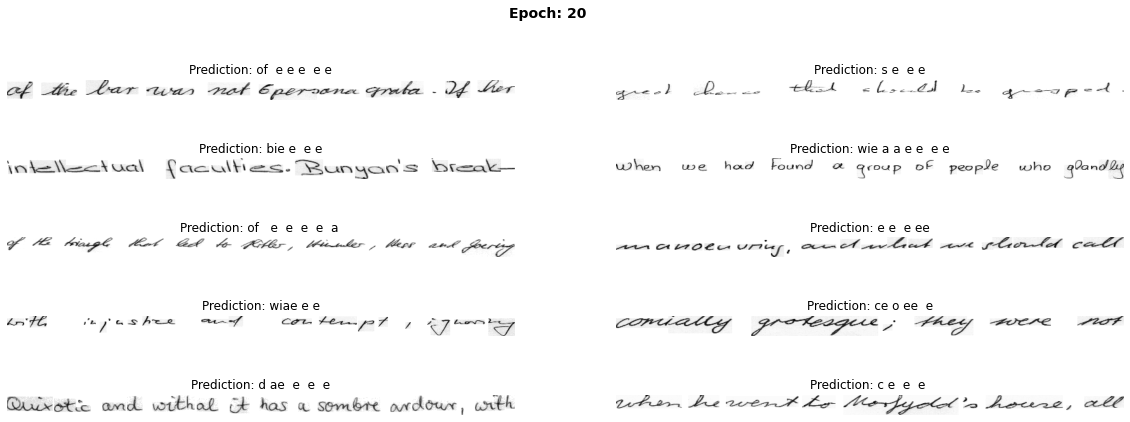

Epoch 22/250
107/107 [==============================] - 95s 830ms/step - loss: 122.6788 - val_loss: 158.2845

Epoch 00022: val_loss did not improve from 124.76925
Epoch 23/250
107/107 [==============================] - 91s 805ms/step - loss: 121.4856 - val_loss: 135.3992

Epoch 00023: val_loss did not improve from 124.76925
Epoch 24/250
107/107 [==============================] - 91s 802ms/step - loss: 120.5996 - val_loss: 137.8180

Epoch 00024: val_loss did not improve from 124.76925
Epoch 25/250
107/107 [==============================] - 92s 808ms/step - loss: 121.9839 - val_loss: 124.4579

Epoch 00025: val_loss improved from 124.76925 to 124.45793, saving model to lines_checkpoint.hdf5
Epoch 26/250
107/107 [==============================] - 92s 806ms/step - loss: 120.1740 - val_loss: 128.7118

Epoch 00026: val_loss did not improve from 124.45793
Epoch 27/250
107/107 [==============================] - 91s 797ms/step - loss: 119.2495 - val_loss: 148.4467

Epoch 00027: val_loss did not 

<Figure size 432x288 with 0 Axes>

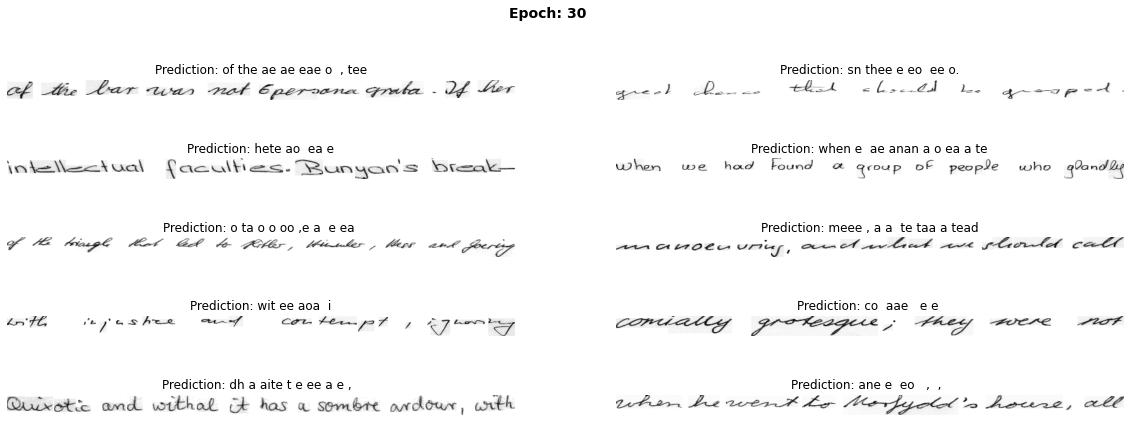

Epoch 32/250
107/107 [==============================] - 89s 787ms/step - loss: 115.2537 - val_loss: 117.2298

Epoch 00032: val_loss improved from 121.70293 to 117.22977, saving model to lines_checkpoint.hdf5
Epoch 33/250
107/107 [==============================] - 89s 787ms/step - loss: 115.0068 - val_loss: 127.3598

Epoch 00033: val_loss did not improve from 117.22977
Epoch 34/250
107/107 [==============================] - 89s 788ms/step - loss: 113.6835 - val_loss: 116.8619

Epoch 00034: val_loss improved from 117.22977 to 116.86192, saving model to lines_checkpoint.hdf5
Epoch 35/250
107/107 [==============================] - 90s 794ms/step - loss: 112.7429 - val_loss: 126.2529

Epoch 00035: val_loss did not improve from 116.86192
Epoch 36/250
107/107 [==============================] - 90s 795ms/step - loss: 112.5619 - val_loss: 282.8960

Epoch 00036: val_loss did not improve from 116.86192
Epoch 37/250
107/107 [==============================] - 91s 798ms/step - loss: 112.9601 - val_l

<Figure size 432x288 with 0 Axes>

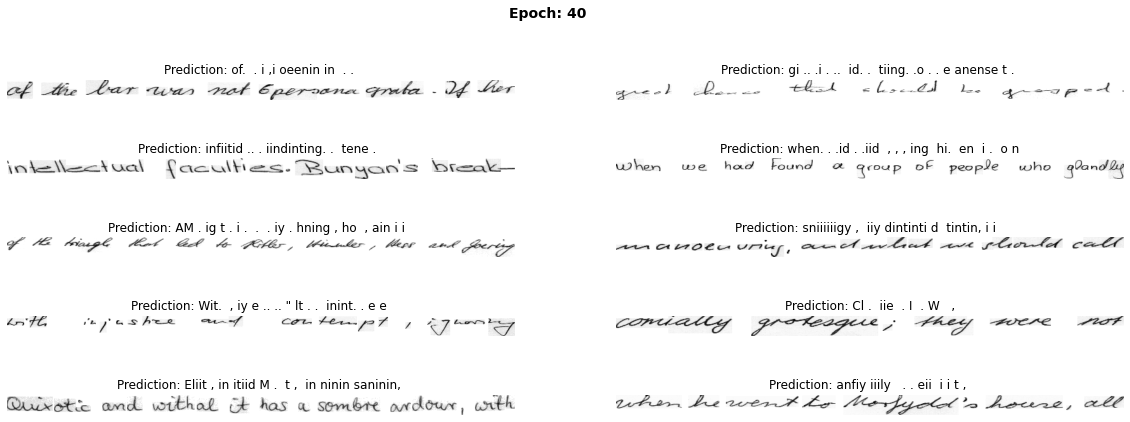

Epoch 42/250
107/107 [==============================] - 89s 787ms/step - loss: 108.5594 - val_loss: 148.4473

Epoch 00042: val_loss did not improve from 115.53791
Epoch 43/250
107/107 [==============================] - 89s 784ms/step - loss: 107.1751 - val_loss: 162.6357

Epoch 00043: val_loss did not improve from 115.53791
Epoch 44/250
107/107 [==============================] - 89s 783ms/step - loss: 105.9051 - val_loss: 109.5782

Epoch 00044: val_loss improved from 115.53791 to 109.57816, saving model to lines_checkpoint.hdf5
Epoch 45/250
107/107 [==============================] - 90s 795ms/step - loss: 106.2992 - val_loss: 109.2339

Epoch 00045: val_loss improved from 109.57816 to 109.23392, saving model to lines_checkpoint.hdf5
Epoch 46/250
107/107 [==============================] - 89s 788ms/step - loss: 106.2863 - val_loss: 111.3093

Epoch 00046: val_loss did not improve from 109.23392
Epoch 47/250
107/107 [==============================] - 90s 790ms/step - loss: 105.7540 - val_l

<Figure size 432x288 with 0 Axes>

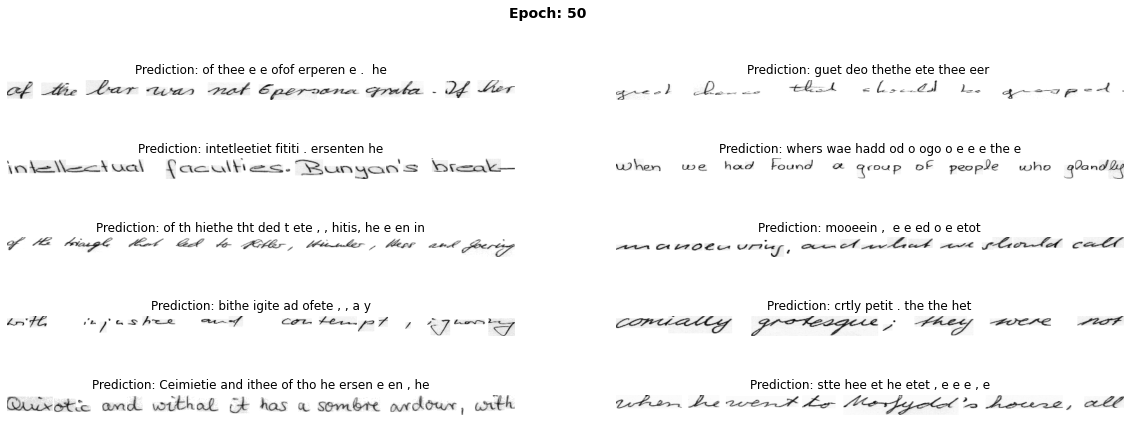

Epoch 52/250
107/107 [==============================] - 92s 808ms/step - loss: 100.1871 - val_loss: 283.3011

Epoch 00052: val_loss did not improve from 105.28337
Epoch 53/250
107/107 [==============================] - 93s 815ms/step - loss: 99.9993 - val_loss: 101.7711

Epoch 00053: val_loss improved from 105.28337 to 101.77112, saving model to lines_checkpoint.hdf5
Epoch 54/250
107/107 [==============================] - 92s 813ms/step - loss: 98.4029 - val_loss: 102.9784

Epoch 00054: val_loss did not improve from 101.77112
Epoch 55/250
107/107 [==============================] - 91s 798ms/step - loss: 97.7672 - val_loss: 100.5136

Epoch 00055: val_loss improved from 101.77112 to 100.51358, saving model to lines_checkpoint.hdf5
Epoch 56/250
107/107 [==============================] - 91s 796ms/step - loss: 96.0722 - val_loss: 105.5848

Epoch 00056: val_loss did not improve from 100.51358
Epoch 57/250
107/107 [==============================] - 89s 786ms/step - loss: 95.7548 - val_loss: 

<Figure size 432x288 with 0 Axes>

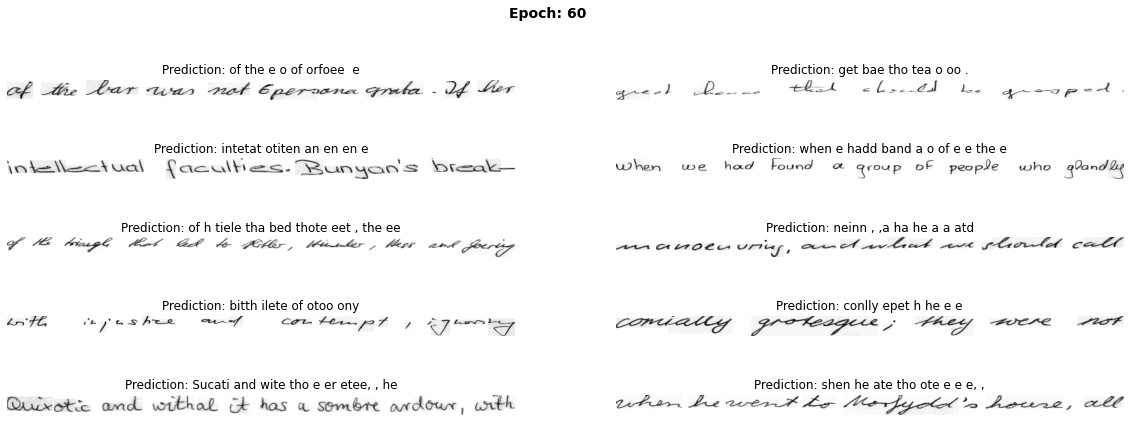

Epoch 62/250
107/107 [==============================] - 89s 786ms/step - loss: 95.4580 - val_loss: 111.1270

Epoch 00062: val_loss did not improve from 95.94414
Epoch 63/250
107/107 [==============================] - 89s 782ms/step - loss: 93.2594 - val_loss: 96.7076

Epoch 00063: val_loss did not improve from 95.94414
Epoch 64/250
107/107 [==============================] - 90s 790ms/step - loss: 92.1494 - val_loss: 94.1167

Epoch 00064: val_loss improved from 95.94414 to 94.11666, saving model to lines_checkpoint.hdf5
Epoch 65/250
107/107 [==============================] - 90s 789ms/step - loss: 90.7203 - val_loss: 97.5409

Epoch 00065: val_loss did not improve from 94.11666
Epoch 66/250
107/107 [==============================] - 92s 812ms/step - loss: 90.4330 - val_loss: 93.6655

Epoch 00066: val_loss improved from 94.11666 to 93.66548, saving model to lines_checkpoint.hdf5
Epoch 67/250
107/107 [==============================] - 92s 807ms/step - loss: 88.4172 - val_loss: 93.9786

Epo

<Figure size 432x288 with 0 Axes>

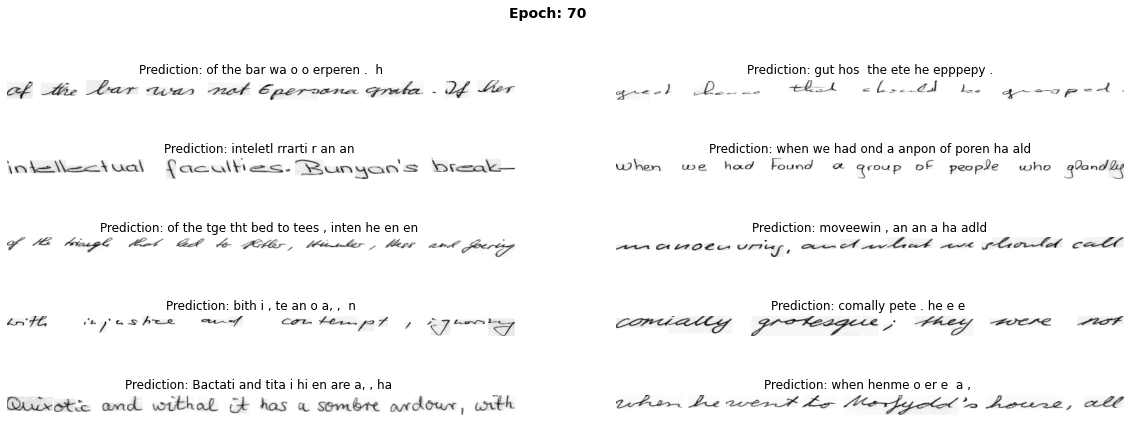

Epoch 72/250
107/107 [==============================] - 94s 825ms/step - loss: 86.9829 - val_loss: 99.6536

Epoch 00072: val_loss did not improve from 91.66848
Epoch 73/250
107/107 [==============================] - 95s 827ms/step - loss: 85.9783 - val_loss: 90.2755

Epoch 00073: val_loss improved from 91.66848 to 90.27545, saving model to lines_checkpoint.hdf5
Epoch 74/250
107/107 [==============================] - 94s 823ms/step - loss: 84.1990 - val_loss: 92.0099

Epoch 00074: val_loss did not improve from 90.27545
Epoch 75/250
107/107 [==============================] - 93s 822ms/step - loss: 86.3578 - val_loss: 91.9520

Epoch 00075: val_loss did not improve from 90.27545
Epoch 76/250
107/107 [==============================] - 94s 830ms/step - loss: 86.7444 - val_loss: 92.1652

Epoch 00076: val_loss did not improve from 90.27545
Epoch 77/250
107/107 [==============================] - 95s 836ms/step - loss: 83.8002 - val_loss: 93.4748

Epoch 00077: val_loss did not improve from 90.27

<Figure size 432x288 with 0 Axes>

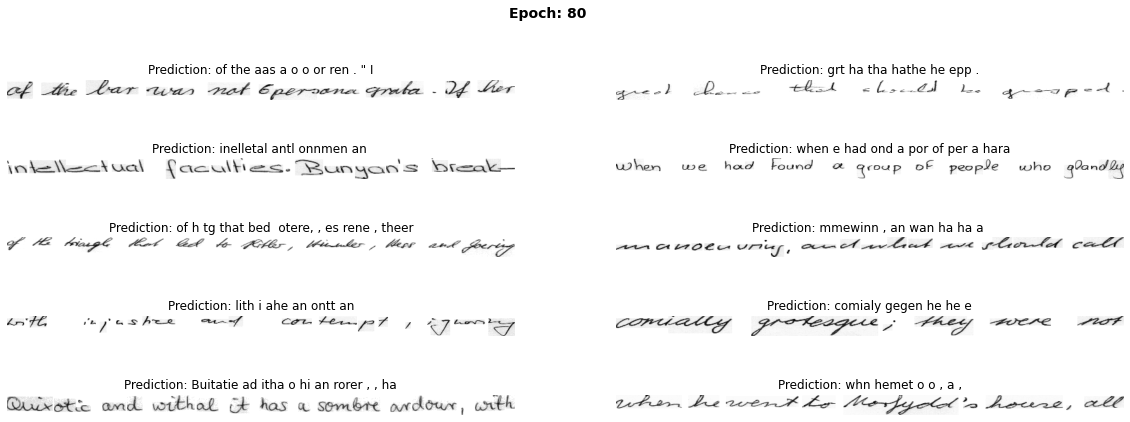

Epoch 82/250
107/107 [==============================] - 90s 791ms/step - loss: 85.4730 - val_loss: 99.4831

Epoch 00082: val_loss did not improve from 89.35918
Epoch 83/250
107/107 [==============================] - 91s 800ms/step - loss: 84.1973 - val_loss: 107.4359

Epoch 00083: val_loss did not improve from 89.35918
Epoch 84/250
107/107 [==============================] - 90s 791ms/step - loss: 82.5268 - val_loss: 89.0788

Epoch 00084: val_loss improved from 89.35918 to 89.07880, saving model to lines_checkpoint.hdf5
Epoch 85/250
107/107 [==============================] - 90s 788ms/step - loss: 82.4106 - val_loss: 93.0019

Epoch 00085: val_loss did not improve from 89.07880
Epoch 86/250
107/107 [==============================] - 90s 793ms/step - loss: 80.8926 - val_loss: 87.4469

Epoch 00086: val_loss improved from 89.07880 to 87.44685, saving model to lines_checkpoint.hdf5
Epoch 87/250
107/107 [==============================] - 90s 790ms/step - loss: 81.0981 - val_loss: 86.9002

Epo

<Figure size 432x288 with 0 Axes>

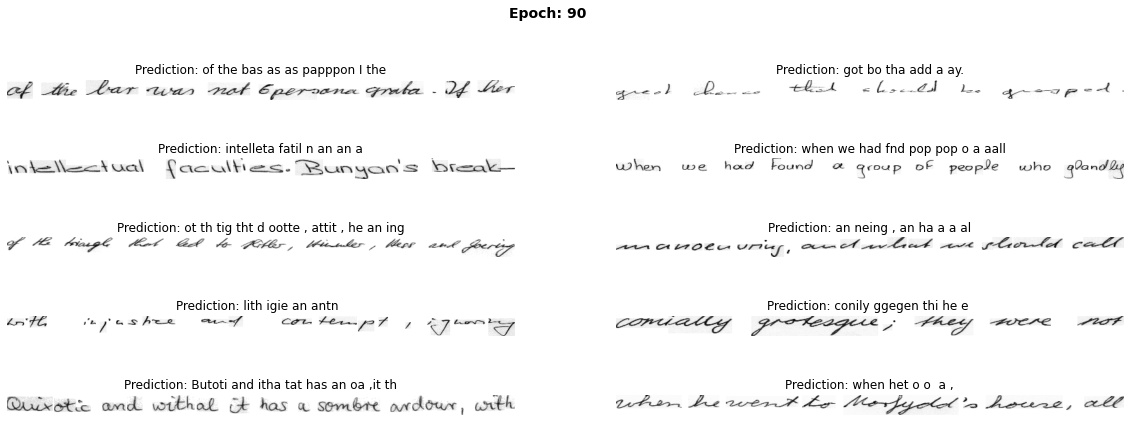

Epoch 92/250
107/107 [==============================] - 91s 802ms/step - loss: 79.9042 - val_loss: 94.0643

Epoch 00092: val_loss did not improve from 86.32323
Epoch 93/250
107/107 [==============================] - 91s 799ms/step - loss: 79.7446 - val_loss: 87.8250

Epoch 00093: val_loss did not improve from 86.32323
Epoch 94/250
107/107 [==============================] - 90s 794ms/step - loss: 78.0960 - val_loss: 85.9895

Epoch 00094: val_loss improved from 86.32323 to 85.98955, saving model to lines_checkpoint.hdf5
Epoch 95/250
107/107 [==============================] - 89s 787ms/step - loss: 78.2024 - val_loss: 87.8768

Epoch 00095: val_loss did not improve from 85.98955
Epoch 96/250
107/107 [==============================] - 90s 789ms/step - loss: 78.3083 - val_loss: 85.8102

Epoch 00096: val_loss improved from 85.98955 to 85.81025, saving model to lines_checkpoint.hdf5
Epoch 97/250
107/107 [==============================] - 90s 788ms/step - loss: 79.4988 - val_loss: 93.9595

Epoc

<Figure size 432x288 with 0 Axes>

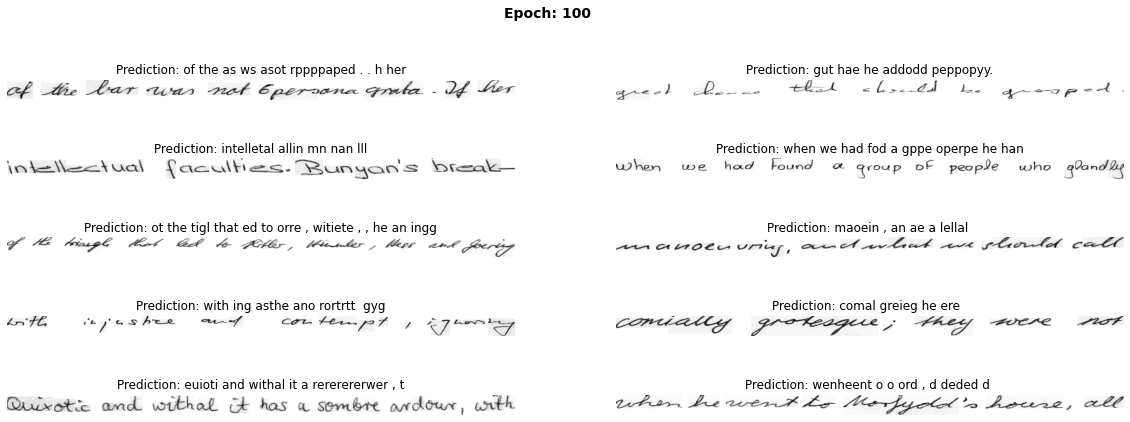

Epoch 102/250
107/107 [==============================] - 88s 777ms/step - loss: 73.2038 - val_loss: 81.9902

Epoch 00102: val_loss improved from 82.41521 to 81.99016, saving model to lines_checkpoint.hdf5
Epoch 103/250
107/107 [==============================] - 90s 791ms/step - loss: 72.2366 - val_loss: 98.0744

Epoch 00103: val_loss did not improve from 81.99016
Epoch 104/250
107/107 [==============================] - 89s 785ms/step - loss: 71.9244 - val_loss: 81.0649

Epoch 00104: val_loss improved from 81.99016 to 81.06486, saving model to lines_checkpoint.hdf5
Epoch 105/250
107/107 [==============================] - 90s 789ms/step - loss: 71.7329 - val_loss: 84.0357

Epoch 00105: val_loss did not improve from 81.06486
Epoch 106/250
107/107 [==============================] - 90s 790ms/step - loss: 71.7909 - val_loss: 98.6407

Epoch 00106: val_loss did not improve from 81.06486
Epoch 107/250
107/107 [==============================] - 91s 795ms/step - loss: 70.9421 - val_loss: 88.4553

<Figure size 432x288 with 0 Axes>

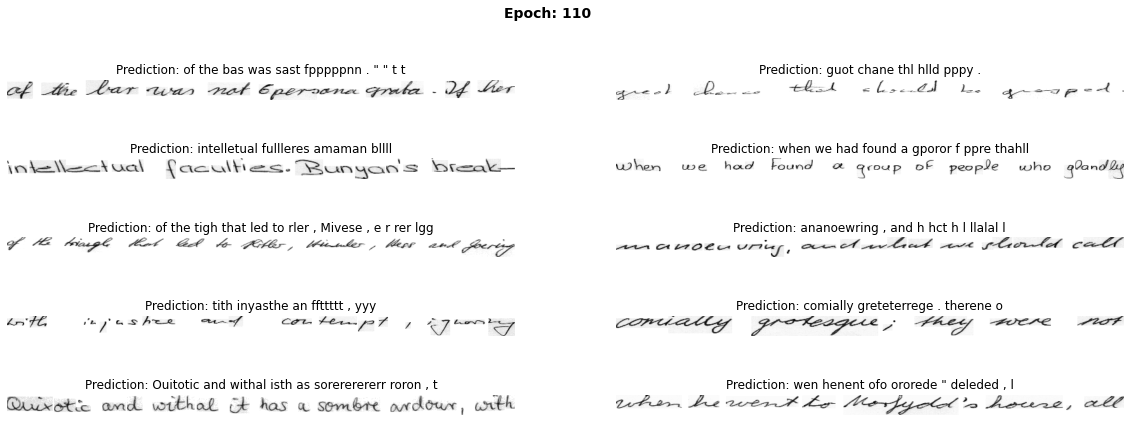

Epoch 112/250
107/107 [==============================] - 91s 803ms/step - loss: 69.1764 - val_loss: 80.4016

Epoch 00112: val_loss did not improve from 79.55816
Epoch 113/250
107/107 [==============================] - 94s 828ms/step - loss: 71.4990 - val_loss: 79.2264

Epoch 00113: val_loss improved from 79.55816 to 79.22644, saving model to lines_checkpoint.hdf5
Epoch 114/250
107/107 [==============================] - 93s 819ms/step - loss: 70.2002 - val_loss: 81.4059

Epoch 00114: val_loss did not improve from 79.22644
Epoch 115/250
107/107 [==============================] - 93s 818ms/step - loss: 67.2143 - val_loss: 79.8085

Epoch 00115: val_loss did not improve from 79.22644
Epoch 116/250
107/107 [==============================] - 94s 824ms/step - loss: 67.3049 - val_loss: 85.9653

Epoch 00116: val_loss did not improve from 79.22644
Epoch 117/250
107/107 [==============================] - 92s 813ms/step - loss: 69.4134 - val_loss: 84.8383

Epoch 00117: val_loss did not improve from

<Figure size 432x288 with 0 Axes>

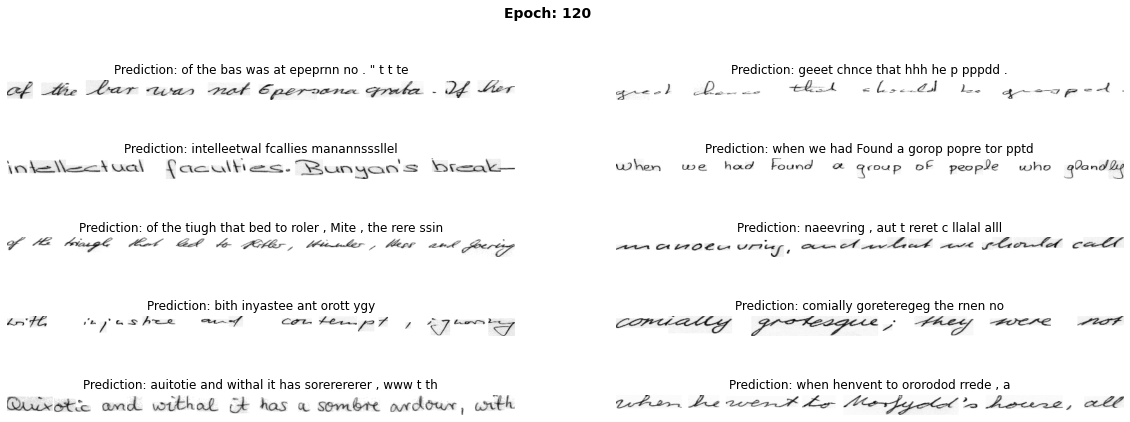

Epoch 122/250
107/107 [==============================] - 89s 785ms/step - loss: 69.4594 - val_loss: 78.6997

Epoch 00122: val_loss did not improve from 77.52783
Epoch 123/250
107/107 [==============================] - 89s 783ms/step - loss: 70.0508 - val_loss: 78.7914

Epoch 00123: val_loss did not improve from 77.52783
Epoch 124/250
107/107 [==============================] - 89s 781ms/step - loss: 72.9576 - val_loss: 79.4591

Epoch 00124: val_loss did not improve from 77.52783
Epoch 125/250
107/107 [==============================] - 88s 778ms/step - loss: 66.5629 - val_loss: 96.8473

Epoch 00125: val_loss did not improve from 77.52783
Epoch 126/250
107/107 [==============================] - 88s 778ms/step - loss: 67.4568 - val_loss: 78.5660

Epoch 00126: val_loss did not improve from 77.52783
Epoch 127/250
107/107 [==============================] - 89s 782ms/step - loss: 68.8775 - val_loss: 77.8857

Epoch 00127: val_loss did not improve from 77.52783
Epoch 128/250
107/107 [===========

<Figure size 432x288 with 0 Axes>

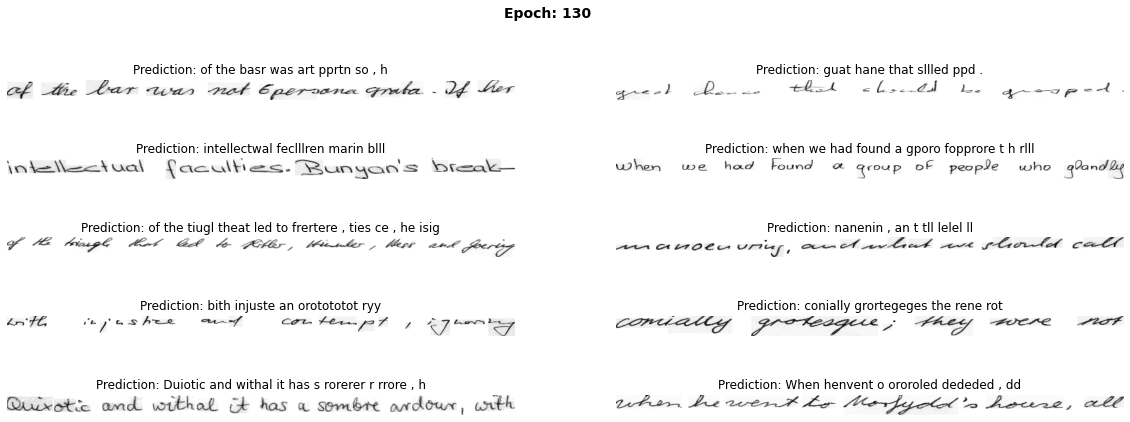

Epoch 132/250
107/107 [==============================] - 88s 774ms/step - loss: 66.0029 - val_loss: 77.0829

Epoch 00132: val_loss did not improve from 76.44843
Epoch 133/250
107/107 [==============================] - 89s 780ms/step - loss: 63.8507 - val_loss: 76.9265

Epoch 00133: val_loss did not improve from 76.44843
Epoch 134/250
107/107 [==============================] - 89s 785ms/step - loss: 63.7042 - val_loss: 83.6748

Epoch 00134: val_loss did not improve from 76.44843
Epoch 135/250
107/107 [==============================] - 89s 781ms/step - loss: 65.1941 - val_loss: 76.6845

Epoch 00135: val_loss did not improve from 76.44843
Epoch 136/250
107/107 [==============================] - 89s 785ms/step - loss: 70.2342 - val_loss: 80.3277

Epoch 00136: val_loss did not improve from 76.44843
Epoch 137/250
107/107 [==============================] - 89s 784ms/step - loss: 65.5829 - val_loss: 75.5352

Epoch 00137: val_loss improved from 76.44843 to 75.53522, saving model to lines_checkp

<Figure size 432x288 with 0 Axes>

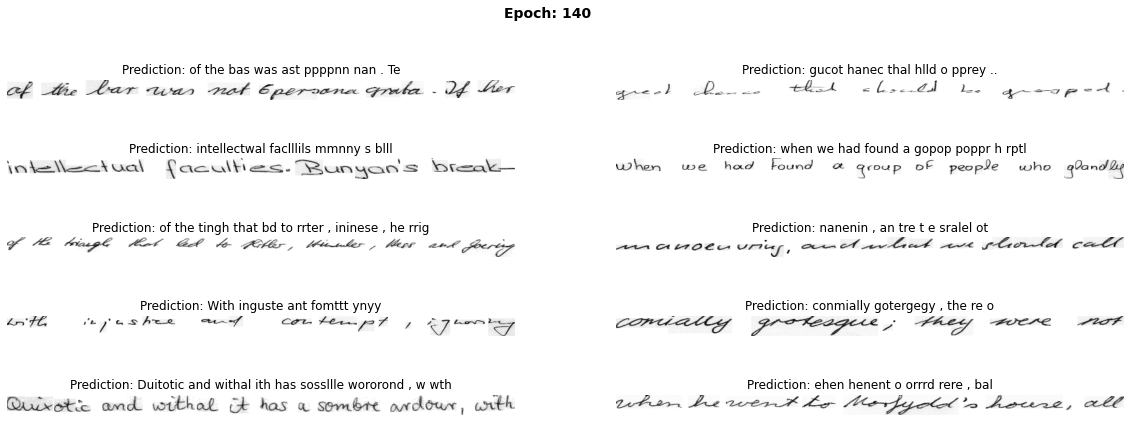

Epoch 142/250
107/107 [==============================] - 89s 781ms/step - loss: 62.5839 - val_loss: 79.2123

Epoch 00142: val_loss did not improve from 75.53522
Epoch 143/250
107/107 [==============================] - 89s 786ms/step - loss: 61.3030 - val_loss: 75.2979

Epoch 00143: val_loss improved from 75.53522 to 75.29794, saving model to lines_checkpoint.hdf5
Epoch 144/250
107/107 [==============================] - 90s 793ms/step - loss: 61.2066 - val_loss: 77.1902

Epoch 00144: val_loss did not improve from 75.29794
Epoch 145/250
107/107 [==============================] - 89s 781ms/step - loss: 60.0884 - val_loss: 75.8781

Epoch 00145: val_loss did not improve from 75.29794
Epoch 146/250
107/107 [==============================] - 89s 785ms/step - loss: 62.4468 - val_loss: 74.9902

Epoch 00146: val_loss improved from 75.29794 to 74.99023, saving model to lines_checkpoint.hdf5
Epoch 147/250
107/107 [==============================] - 89s 783ms/step - loss: 64.2270 - val_loss: 80.3762

<Figure size 432x288 with 0 Axes>

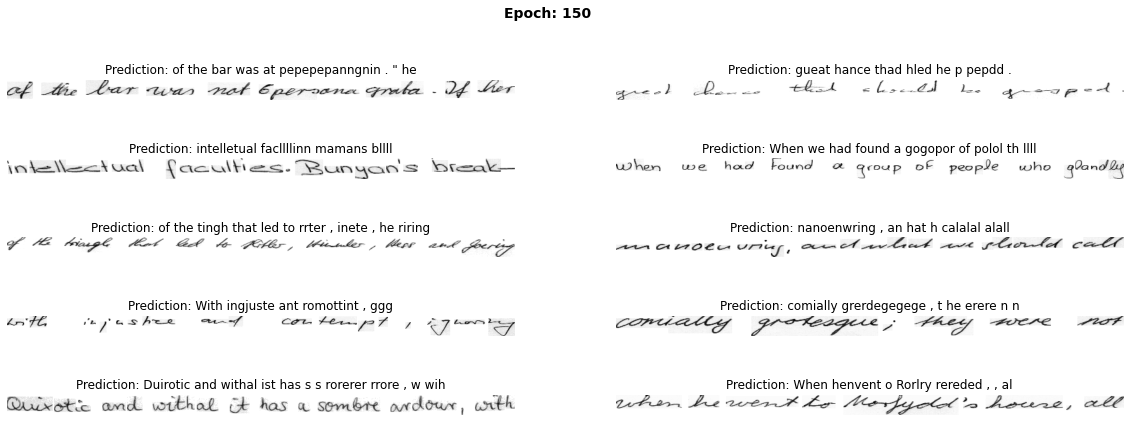

Epoch 152/250
107/107 [==============================] - 88s 777ms/step - loss: 61.5745 - val_loss: 77.2295

Epoch 00152: val_loss did not improve from 73.73751
Epoch 153/250
107/107 [==============================] - 88s 778ms/step - loss: 60.7772 - val_loss: 84.7763

Epoch 00153: val_loss did not improve from 73.73751
Epoch 154/250
107/107 [==============================] - 88s 776ms/step - loss: 64.9797 - val_loss: 75.9733

Epoch 00154: val_loss did not improve from 73.73751
Epoch 155/250
107/107 [==============================] - 89s 782ms/step - loss: 61.7625 - val_loss: 77.8646

Epoch 00155: val_loss did not improve from 73.73751
Epoch 156/250
107/107 [==============================] - 88s 778ms/step - loss: 60.7950 - val_loss: 77.8631

Epoch 00156: val_loss did not improve from 73.73751
Epoch 157/250
107/107 [==============================] - 89s 782ms/step - loss: 58.6049 - val_loss: 75.1728

Epoch 00157: val_loss did not improve from 73.73751
Epoch 158/250
107/107 [===========

<Figure size 432x288 with 0 Axes>

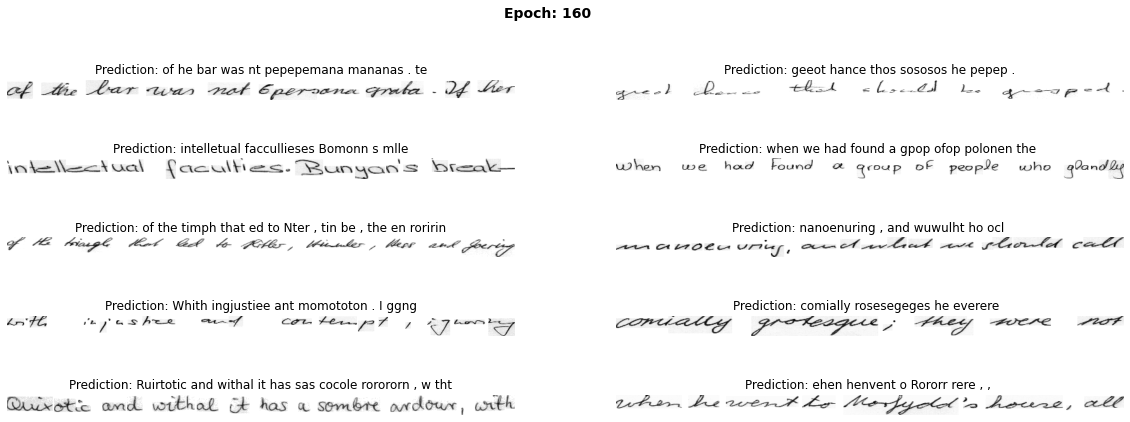

Epoch 162/250
107/107 [==============================] - 89s 781ms/step - loss: 60.9003 - val_loss: 73.1803

Epoch 00162: val_loss improved from 73.73751 to 73.18027, saving model to lines_checkpoint.hdf5
Epoch 163/250
107/107 [==============================] - 89s 783ms/step - loss: 58.9928 - val_loss: 74.1062

Epoch 00163: val_loss did not improve from 73.18027
Epoch 164/250
107/107 [==============================] - 89s 779ms/step - loss: 56.7161 - val_loss: 75.0431

Epoch 00164: val_loss did not improve from 73.18027
Epoch 165/250
107/107 [==============================] - 89s 787ms/step - loss: 58.0145 - val_loss: 79.3951

Epoch 00165: val_loss did not improve from 73.18027
Epoch 166/250
107/107 [==============================] - 89s 785ms/step - loss: 58.6561 - val_loss: 73.2533

Epoch 00166: val_loss did not improve from 73.18027
Epoch 167/250
107/107 [==============================] - 89s 785ms/step - loss: 57.9509 - val_loss: 76.7682

Epoch 00167: val_loss did not improve from

<Figure size 432x288 with 0 Axes>

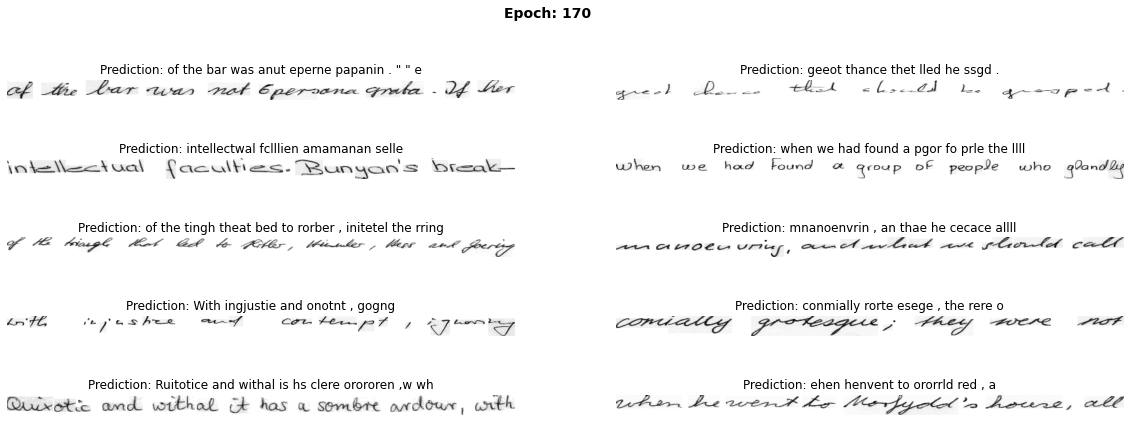

Epoch 172/250
107/107 [==============================] - 89s 780ms/step - loss: 56.7073 - val_loss: 75.3969

Epoch 00172: val_loss did not improve from 72.64902
Epoch 173/250
107/107 [==============================] - 88s 774ms/step - loss: 59.8596 - val_loss: 99.0656

Epoch 00173: val_loss did not improve from 72.64902
Epoch 174/250
107/107 [==============================] - 88s 776ms/step - loss: 56.7475 - val_loss: 76.2316

Epoch 00174: val_loss did not improve from 72.64902
Epoch 175/250
107/107 [==============================] - 89s 784ms/step - loss: 57.3293 - val_loss: 74.2310

Epoch 00175: val_loss did not improve from 72.64902
Epoch 176/250
107/107 [==============================] - 90s 791ms/step - loss: 56.3847 - val_loss: 72.3579

Epoch 00176: val_loss improved from 72.64902 to 72.35789, saving model to lines_checkpoint.hdf5
Epoch 177/250
107/107 [==============================] - 89s 782ms/step - loss: 56.8434 - val_loss: 74.2868

Epoch 00177: val_loss did not improve from

<Figure size 432x288 with 0 Axes>

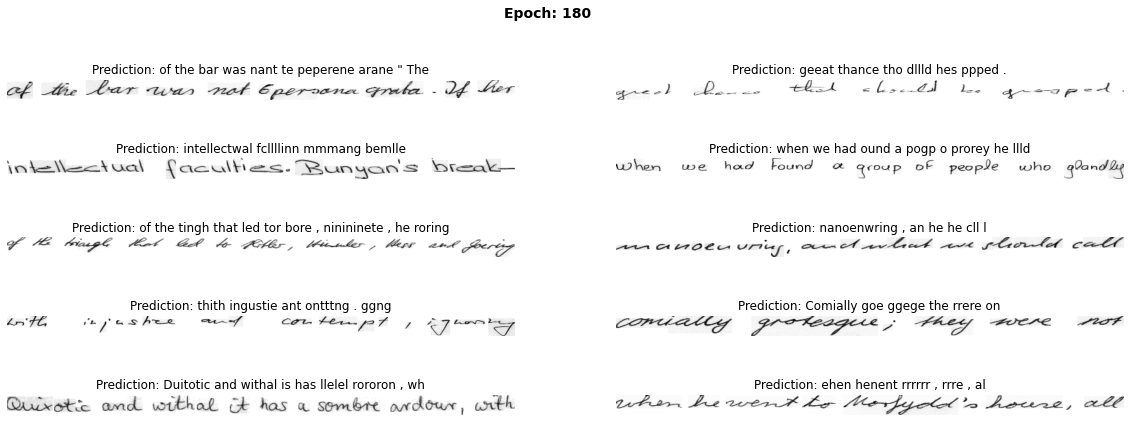

Epoch 182/250
107/107 [==============================] - 89s 783ms/step - loss: 55.0280 - val_loss: 72.5320

Epoch 00182: val_loss did not improve from 72.35789
Epoch 183/250
107/107 [==============================] - 89s 786ms/step - loss: 54.0551 - val_loss: 74.8514

Epoch 00183: val_loss did not improve from 72.35789
Epoch 184/250
107/107 [==============================] - 89s 785ms/step - loss: 54.4509 - val_loss: 79.6808

Epoch 00184: val_loss did not improve from 72.35789
Epoch 185/250
107/107 [==============================] - 89s 786ms/step - loss: 56.3204 - val_loss: 72.7235

Epoch 00185: val_loss did not improve from 72.35789
Epoch 186/250
107/107 [==============================] - 90s 795ms/step - loss: 53.5582 - val_loss: 76.4281

Epoch 00186: val_loss did not improve from 72.35789
Epoch 187/250
107/107 [==============================] - 90s 792ms/step - loss: 54.4204 - val_loss: 79.5371

Epoch 00187: val_loss did not improve from 72.35789
Epoch 188/250
107/107 [===========

<Figure size 432x288 with 0 Axes>

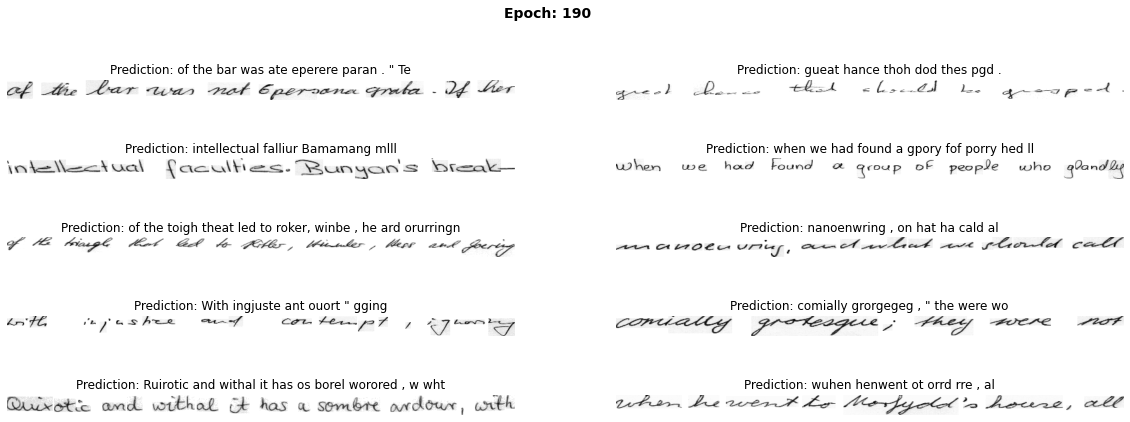

Epoch 192/250
107/107 [==============================] - 89s 785ms/step - loss: 52.2692 - val_loss: 72.6044

Epoch 00192: val_loss did not improve from 72.35789
Epoch 193/250
107/107 [==============================] - 89s 788ms/step - loss: 53.6700 - val_loss: 80.8687

Epoch 00193: val_loss did not improve from 72.35789
Epoch 194/250
107/107 [==============================] - 89s 784ms/step - loss: 55.7438 - val_loss: 75.3519

Epoch 00194: val_loss did not improve from 72.35789
Epoch 195/250
107/107 [==============================] - 89s 782ms/step - loss: 51.9926 - val_loss: 70.2066

Epoch 00195: val_loss improved from 72.35789 to 70.20665, saving model to lines_checkpoint.hdf5
Epoch 196/250
107/107 [==============================] - 89s 784ms/step - loss: 55.4408 - val_loss: 73.7096

Epoch 00196: val_loss did not improve from 70.20665
Epoch 197/250
107/107 [==============================] - 89s 782ms/step - loss: 54.4324 - val_loss: 72.8260

Epoch 00197: val_loss did not improve from

<Figure size 432x288 with 0 Axes>

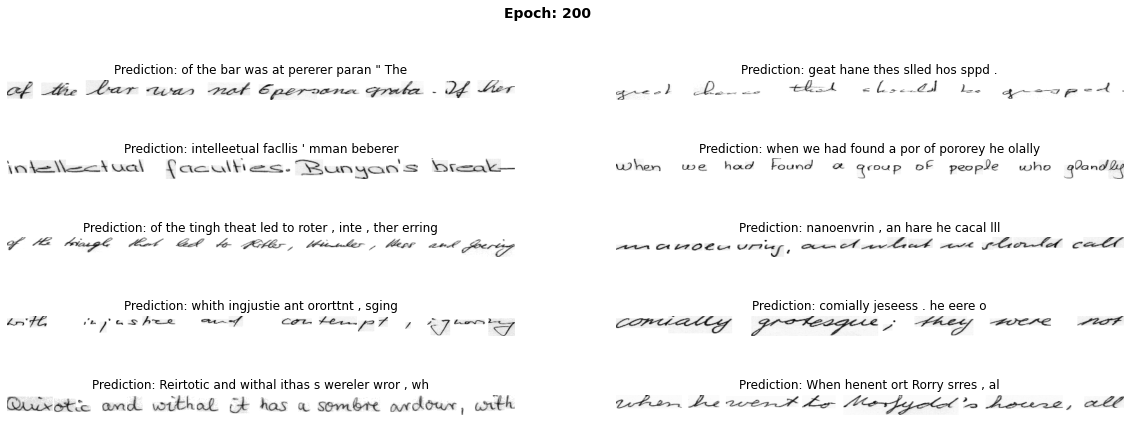

Epoch 202/250
107/107 [==============================] - 88s 774ms/step - loss: 54.3057 - val_loss: 71.8671

Epoch 00202: val_loss did not improve from 70.20665
Epoch 203/250
107/107 [==============================] - 88s 777ms/step - loss: 52.6882 - val_loss: 80.0543

Epoch 00203: val_loss did not improve from 70.20665
Epoch 204/250
107/107 [==============================] - 88s 777ms/step - loss: 52.3474 - val_loss: 75.6757

Epoch 00204: val_loss did not improve from 70.20665
Epoch 205/250
107/107 [==============================] - 88s 772ms/step - loss: 53.5917 - val_loss: 79.4498

Epoch 00205: val_loss did not improve from 70.20665
Epoch 206/250
107/107 [==============================] - 89s 787ms/step - loss: 55.0121 - val_loss: 71.3730

Epoch 00206: val_loss did not improve from 70.20665
Epoch 207/250
107/107 [==============================] - 89s 782ms/step - loss: 54.7499 - val_loss: 71.9226

Epoch 00207: val_loss did not improve from 70.20665
Epoch 208/250
107/107 [===========

<Figure size 432x288 with 0 Axes>

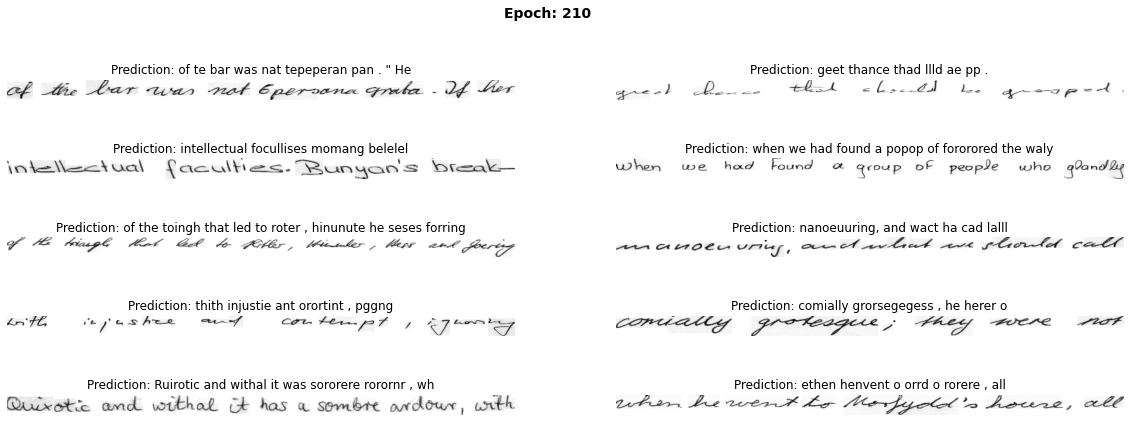

Epoch 212/250
107/107 [==============================] - 91s 804ms/step - loss: 52.3645 - val_loss: 73.1826

Epoch 00212: val_loss did not improve from 70.20665
Epoch 213/250
107/107 [==============================] - 92s 809ms/step - loss: 52.1208 - val_loss: 78.5404

Epoch 00213: val_loss did not improve from 70.20665
Epoch 214/250
107/107 [==============================] - 93s 815ms/step - loss: 49.8226 - val_loss: 73.1747

Epoch 00214: val_loss did not improve from 70.20665
Epoch 215/250
107/107 [==============================] - 93s 817ms/step - loss: 51.3532 - val_loss: 70.0936

Epoch 00215: val_loss improved from 70.20665 to 70.09364, saving model to lines_checkpoint.hdf5
Epoch 216/250
107/107 [==============================] - 91s 797ms/step - loss: 50.6470 - val_loss: 82.0794

Epoch 00216: val_loss did not improve from 70.09364
Epoch 217/250
107/107 [==============================] - 91s 801ms/step - loss: 53.2056 - val_loss: 76.5701

Epoch 00217: val_loss did not improve from

<Figure size 432x288 with 0 Axes>

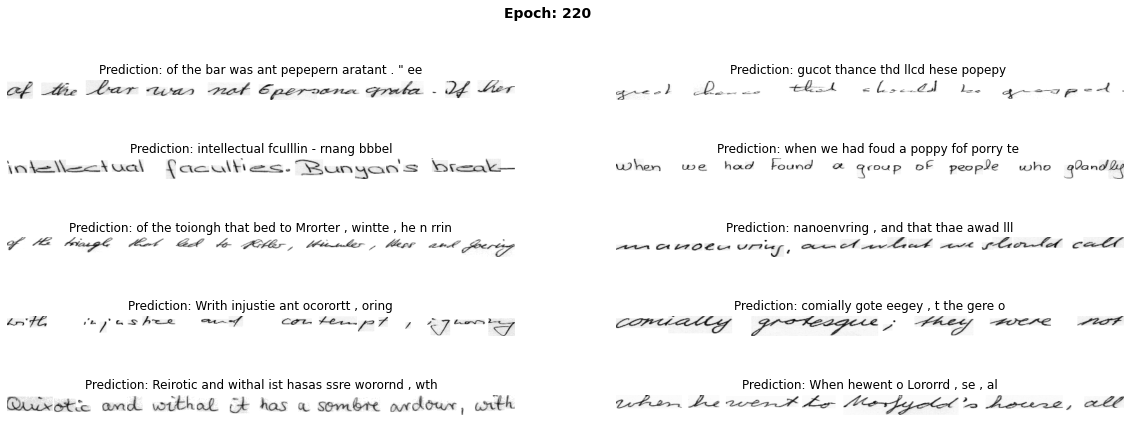

Epoch 222/250
107/107 [==============================] - 90s 790ms/step - loss: 53.6893 - val_loss: 70.1450

Epoch 00222: val_loss did not improve from 69.04089
Epoch 223/250
107/107 [==============================] - 91s 800ms/step - loss: 49.9879 - val_loss: 69.7582

Epoch 00223: val_loss did not improve from 69.04089
Epoch 224/250
107/107 [==============================] - 91s 804ms/step - loss: 53.4333 - val_loss: 79.2426

Epoch 00224: val_loss did not improve from 69.04089
Epoch 225/250
107/107 [==============================] - 91s 801ms/step - loss: 49.9767 - val_loss: 72.5169

Epoch 00225: val_loss did not improve from 69.04089
Epoch 226/250
107/107 [==============================] - 91s 798ms/step - loss: 49.5597 - val_loss: 69.2463

Epoch 00226: val_loss did not improve from 69.04089
Epoch 227/250
107/107 [==============================] - 91s 805ms/step - loss: 49.1259 - val_loss: 79.9028

Epoch 00227: val_loss did not improve from 69.04089
Epoch 228/250
107/107 [===========

<Figure size 432x288 with 0 Axes>

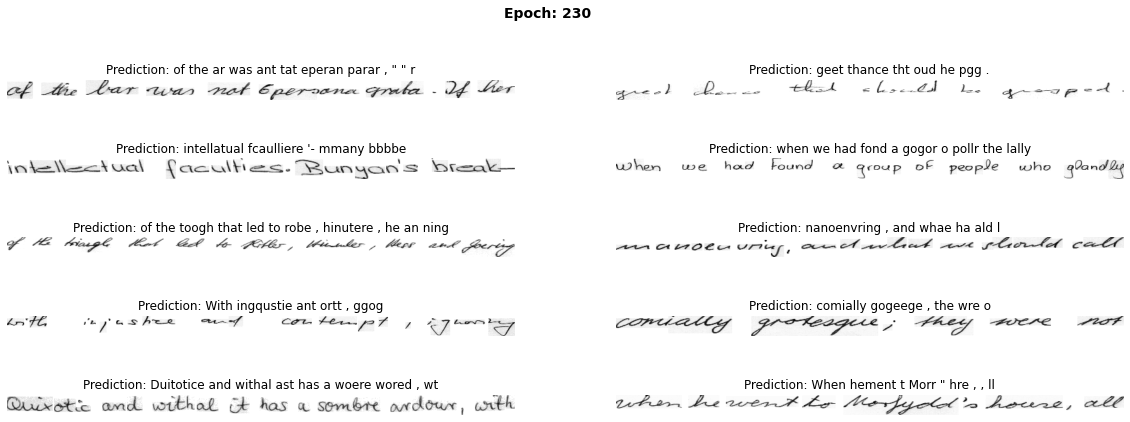

Epoch 232/250


In [ ]:
# Un autre entrainement inachevé

## Déduction - Prédiction - Conclusion

In [ ]:
model.load_weights('/content/drive/My Drive/2lines_checkpoint.hdf5')

In [ ]:
from keras.preprocessing import image
import matplotlib.image as mpimg
import numpy as np

In [ ]:
# Récupération de la prediction du modèle par extraction de toutes les couches à l'exception de la couche CTC loss

prediction_model = keras.models.Model(model.get_layer(name="image").input, 
                                      model.get_layer(name="dense").output
                                      )
prediction_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 800, 32, 1)]      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 800, 32, 32)       320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 400, 16, 32)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 400, 16, 64)       18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 200, 8, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 200, 8, 128)       73856     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 200, 8, 128)       1475

In [ ]:
wandb.log({"prediction_for_each_10_epoch": [wandb.Image(fig, caption="epoch_"+str(i)) for i, fig in enumerate(figures_list)]})
# cette commande permet de recupérer les images de la liste figures_list et les stocker dans mon compte wandb

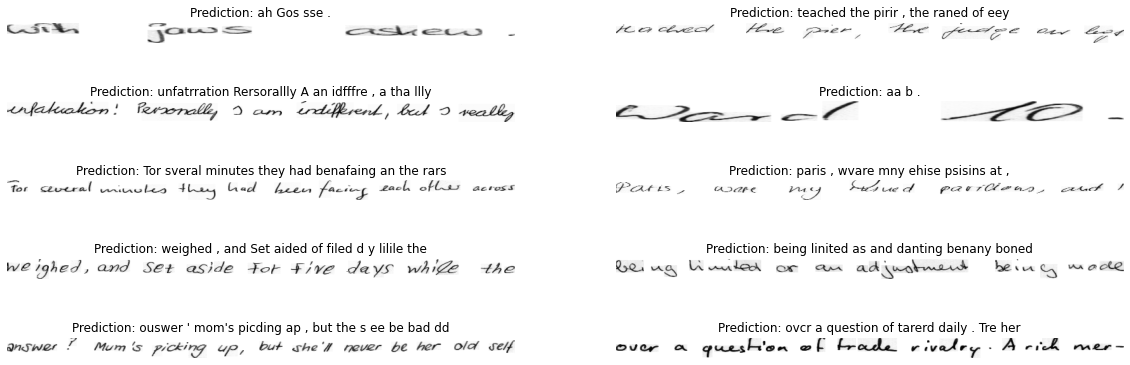

In [ ]:
#  Visualisation des prédictions sur certains échantillons de validation

for batch in validation_data.take(1):

    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = ctc_decoder(preds)

    orig_texts = []

    for label in batch_labels:
      
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    fig , ax = plt.subplots(5, 2, figsize=(20, 7))
    for i in range(10):

        img = (batch_images[i, :, :, 0] * 255).numpy().astype("uint8")
        img = img.T       # La transposition permet de retrouver le format initial de l'image 
        
        title = f"Prediction: {pred_texts[i]}"
        
        ax[i % 5, i % 2].imshow(img, cmap="gray")
        ax[i % 5, i % 2].set_title(title)
        ax[i % 5, i % 2].axis("off")
        
plt.show()


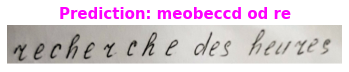

In [ ]:
txt ='/content/drive/My Drive/recherche.png'
test_image = image.load_img(txt, target_size = (32, 800))
test_image = image.img_to_array(test_image)/255
test_image = test_image.T
#test_image = np.expand_dims(test_image, axis = 0)

img_proba = prediction_model.predict(test_image)
text_proba = ctc_decoder(img_proba)[1]

img = mpimg.imread(txt)  

plt.axis('off')
plt.title(f"Prediction: {text_proba}", color = (1, 0, 1), fontsize = 15, fontweight = 'bold')
imgplot = plt.imshow(img, cmap='gray')

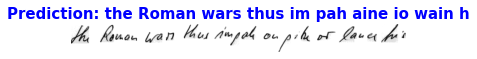

In [ ]:
txt ='/content/drive/My Drive/the roman.png'

test_image = image.load_img(txt, target_size = (32, 800))
test_image = image.img_to_array(test_image)/255
test_image = test_image.T


img_proba = prediction_model.predict(test_image)
text_proba = ctc_decoder(img_proba)[1]

img = mpimg.imread(txt)  

plt.axis('off')
plt.title(f"Prediction: {text_proba}", color = (0, 0, 1), fontsize = 15, fontweight = 'bold')
imgplot = plt.imshow(img, cmap='gray')

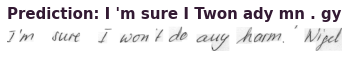

In [ ]:
txt ='/content/drive/My Drive/harmony.png'

test_image = image.load_img(txt, target_size = (32, 800))
test_image = image.img_to_array(test_image)/255
test_image = test_image.T


img_proba = prediction_model.predict(test_image)
text_proba = ctc_decoder(img_proba)[1]

img = mpimg.imread(txt)  

plt.axis('off')
plt.title(f"Prediction: {text_proba}", color = (0.2, .1, .2), fontsize = 15, fontweight = 'bold')
imgplot = plt.imshow(img, cmap='gray')

In [ ]:
txt ='thor.jpg' # Préciser le chemin local
test_image = image.load_img(txt, target_size = 32, 800))
test_image = image.img_to_array(test_image)/255
test_image = np.expand_dims(test_image, axis = 0)
​
proba = round(100*classifier.predict_proba(test_image)[0][1], 2)

if proba < 50:
    santa_or_not = 'Not Santa'
    proba = round(100-proba, 2)
else:
    santa_or_not = 'Santa'
img = mpimg.imread(txt)
plt.axis('off')
plt.text(-10, -15, santa_or_not+': '+str(proba)+'%', color = (1, 0, 0), fontsize = 20, fontweight = 'extra bold')
imgplot = plt.imshow(img)

In [ ]:
pip install exam_utils

ERROR: Could not find a version that satisfies the requirement exam_utils (from versions: none)
ERROR: No matching distribution found for exam_utils


In [ ]:

from exam_utils import generate_envs

ModuleNotFoundError: ignored